# To use this notebook, have data of the following form in a CSV file
![data format example](Ben_CSV_example.jpg)


# Contents

#### 1. Prepare for analysis (import packages and set working directory)
#### 2. Read in, tidy, and explore the data
#### 3. Generate speed trace
#### 4. Generate OffFood/OnFood comparison bar plots (including BSR)
#### 5. Generate phenotype heatmap

# 1 - Prepare for analysis

## 1.1 - Import required packages

In [1]:
import os  # <- package used to work with system filepaths
import pandas as pd  # <- package used to import and organize data
import numpy as np  # <- package used to import and organize data
import math
import seaborn as sns  # <- package used to plot graphs
from matplotlib import pyplot as plt  # <- another package used to plot graphs
from itertools import cycle  # <- package used to iterate down rows
from ipywidgets import widgets  # <- widget tool to generate button
from IPython.display import display  # <- displays button
from tkinter import Tk, filedialog  # <- Tkinter is a GUI package
from tqdm.notebook import tqdm
import pingouin as pg
from pingouin import ttest
from scipy.stats import ttest_ind
pd.set_option('display.max_columns', 50)
print("done step 1")

done step 1


## 1.2 - Set working directory to where the CSV file with experiment data is

In [2]:
os.getcwd()
os.chdir('/Users/Joseph/Desktop/GRC_Data')

# 2 - Read in, tidy, and explore the data

## 2.1 - Read in the data, check its size and format

In [3]:
TotalConcatenated = pd.read_csv('BSR_baseline_output.csv')

print(TotalConcatenated.shape)
print(TotalConcatenated.head())
# print(TotalConcatenated.tail())

(4761610, 20)
   Unnamed: 0  time_bin  worm      time     speed          x          y  \
0           0       3.0     1  2.666125  0.352013  21.461862  21.220437   
1           1       3.0     8  2.546000  0.395982  27.712055  24.464291   
2           2       3.0    85  2.744000  0.324933  22.659617  30.046517   
3           3       3.0   165  2.776800  0.280820  19.180400  35.189900   
4           4       3.0   249  2.817250  0.216575  19.060475  24.959625   

   angularspeed  pathlength       kink  bias      curve       dir      crab  \
0    134.875000    0.125875  82.212500   1.0  58.775000  0.004250  0.146800   
1     44.490909    0.181091  59.918182   1.0  47.163636  0.000364  0.067409   
2     26.583333    0.098000  40.850000   1.0  31.516667  0.000000  0.047967   
3     25.580000    0.069400  15.100000   1.0  42.300000  0.000000  0.022700   
4     10.175000    0.044500  61.125000   1.0  38.300000  0.000000  0.031100   

     length   midline     width  morphwidth      area      S

## 2.2 - Get list of strains in the data set

In [4]:
TotalConcatenated_strains = TotalConcatenated.groupby(["Strain", "worm"], as_index=False).mean()
TotalConcatenated_strains[['Genotype', 'Treatment']] = TotalConcatenated_strains['Strain'].str.split('_', 1, expand = True)
TotalConcatenated_strains = TotalConcatenated_strains.dropna()
TotalConcatenated_strains = TotalConcatenated_strains.Genotype.unique()

# print(TotalConcatenated_strains.head())
# print(TotalConcatenated_strains.tail())

print(TotalConcatenated_strains)

all_strains = pd.DataFrame(TotalConcatenated_strains, columns = ['Genotype'])
print(all_strains)
print(len(all_strains))

['C29E4.10(ok2752)' 'F53B2.5(ok226)' 'N2' 'Y18D10A.22(ok3535)'
 'acr-12(ok367)' 'acr-3(ok2049)' 'acr-6(ok3117)' 'acr-8(ok1240)'
 'bas-1(tm351)' 'cat-1(e1111)' 'cat-1(ok411)' 'cat-2(e1112)'
 'cat-4(e1141)' 'cat-4(tm773)' 'catp-6(ok347)' 'catp-6(ok3473)'
 'chd-7(tm6183)' 'crls-1(tm2542)' 'crls-1(tm2575)' 'djr-1.2(tm1346)'
 'dnj-25(ok422)' 'dop-1(vs101)' 'dop-3(ok295)' 'dop-3(tm1356)'
 'gba-3(gk3287)' 'gba-3(tm3302)' 'gck-3(tm1223)' 'gck-3(tm1296)'
 'glo-1(tm15275)' 'glo-1(tm3240)' 'glo-1(zu391)' 'hipr-1(tm14191)'
 'let-19(gk149538)' 'let-19(os33)' 'lrk-1(tm1898)' 'lrk-1(tm7568)'
 'mbk-1(pk1389)' 'mbl-1(tm1207)' 'mbl-1(tm1277)' 'mex-3(spr-10)'
 'mex-3(spr5)' 'mex-3(spr6)' 'mex-3(spr7)' 'mex-3(spr9)' 'mex-3(zu155)'
 'pdr-1(gk448)' 'pdr-1(tm598)' 'pink-1(ok3538)' 'pink-1(tm1779)'
 'rskd-1(gk1208)' 'set-2(n4589)' 'set-2(ok952)' 'sipa-1(ok879)'
 'snb-5(ok1434)' 'tag-138(gk247)' 'unc-10(ad591)' 'vps-35(hu68)'
 'vps-35(ok1880)']
              Genotype
0     C29E4.10(ok2752)
1       F53B2.5(ok22

/var/folders/31/jpj6mpsx60d9829cymplqfsh0000gn/T/ipykernel_2189/2452573797.py:2: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  TotalConcatenated_strains[['Genotype', 'Treatment']] = TotalConcatenated_strains['Strain'].str.split('_', 1, expand = True)


## 2.3 - Determine the range for which you want to analyze data

In [7]:
start = 100  # <----- set the start time of the range
point = 400  # <----- set the end time of your range

TotalConcatenated_chunked0 = TotalConcatenated[TotalConcatenated["time"] >= start]
TotalConcatenated_chunked = TotalConcatenated_chunked0[TotalConcatenated_chunked0["time"] <= point]

## 2.4 - Find average measures for each worm (across duration of specified range), split 'Strain' column into two

Ex: 'N2_OnFood' becomes 'N2' & 'OnFood'

In [35]:
TotalConcatenated_mean = TotalConcatenated_chunked.groupby(["Strain", "worm"], as_index=False).mean()
TotalConcatenated_mean[['Genotype', 'Treatment']] = TotalConcatenated_mean['Strain'].str.split('_', expand = True)
TotalConcatenated_mean[['Gene','Allele']]=TotalConcatenated_mean['Genotype'].str.split('(',expand=True)
TotalConcatenated_mean['Allele']=TotalConcatenated_mean['Allele'].str[:-1]
print(TotalConcatenated_mean.groupby(['Gene'], as_index = False).mean())
# # TotalConcatenated_mean['Gene']=TotalConcatenated['Gene'].fill_na('N2')
# print(TotalConcatenated_mean.Gene.unique())

# SELECT ONLY NECESSARY COLUMNS
TotalConcatenated_worm_avg_speed = TotalConcatenated_mean[['Gene','Genotype', 'Treatment', 'Strain', 'speed']]
print(TotalConcatenated_worm_avg_speed)
By_gene_avg_speed=TotalConcatenated_mean[['Gene','Treatment', 'speed']]

          Gene         worm     Unnamed: 0    time_bin        time     speed  \
0     C29E4.10    39.353846   10196.556359  245.196154  244.696734  0.101876   
1      F53B2.5    23.789474    6231.958700  237.236842  236.736220  0.087401   
2           N2  3529.069508  445511.837267  232.796287  232.294627  0.152551   
3   Y18D10A.22    64.975000   11635.236415  222.785000  222.283190  0.097559   
4       acr-12   201.604377   22816.587024  232.372054  231.868011  0.148403   
5        acr-3   153.434874   17550.602188  238.246849  237.743322  0.144278   
6        acr-6   211.509466   22807.223369  229.845814  229.344949  0.129040   
7        acr-8   156.937768   22169.465123  224.504292  224.001313  0.117722   
8        bas-1    91.003597   12230.079536  240.426259  239.926890  0.161754   
9        cat-1   350.020695   36617.087606  244.560394  244.060056  0.133156   
10       cat-2   614.938470   65300.377179  231.490199  230.989748  0.198223   
11       cat-4    95.350993    9742.8751

/var/folders/31/jpj6mpsx60d9829cymplqfsh0000gn/T/ipykernel_42384/3356203893.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  print(TotalConcatenated_mean.groupby(['Gene'], as_index = False).mean())


## 2.5 - Find average speed measures for each genotype and treatment (across duration of specified range)

In [72]:
TotalConcatenated_avg_speed = TotalConcatenated_worm_avg_speed.groupby(['Gene','Strain', 'Treatment', 'Genotype'], as_index = False).mean()
print(TotalConcatenated_avg_speed)
print(len(TotalConcatenated_avg_speed['Genotype'].unique()))
# print(TotalConcatenated_avg_speed['speed'][1])

ByGene_avg_speed = By_gene_avg_speed.groupby(['Gene','Treatment'], as_index = False).mean()
print(ByGene_avg_speed)

         Gene                    Strain Treatment          Genotype     speed
0    C29E4.10  C29E4.10(ok2752)_OffFood   OffFood  C29E4.10(ok2752)  0.146825
1    C29E4.10   C29E4.10(ok2752)_OnFood    OnFood  C29E4.10(ok2752)  0.063348
2     F53B2.5    F53B2.5(ok226)_OffFood   OffFood    F53B2.5(ok226)  0.122221
3     F53B2.5     F53B2.5(ok226)_OnFood    OnFood    F53B2.5(ok226)  0.062077
4          N2                N2_OffFood   OffFood                N2  0.193063
..        ...                       ...       ...               ...       ...
109    unc-10      unc-10(ad591)_OnFood    OnFood     unc-10(ad591)  0.053308
110    vps-35      vps-35(hu68)_OffFood   OffFood      vps-35(hu68)  0.068205
111    vps-35       vps-35(hu68)_OnFood    OnFood      vps-35(hu68)  0.053125
112    vps-35    vps-35(ok1880)_OffFood   OffFood    vps-35(ok1880)  0.086613
113    vps-35     vps-35(ok1880)_OnFood    OnFood    vps-35(ok1880)  0.061525

[114 rows x 5 columns]
58
        Gene Treatment     speed
0   

## 2.6 - Generate dataframe containing only data for N2 and CB1112 for use in speed trace

In [76]:
print(TotalConcatenated_avg_speed.Genotype.unique())
print(len(TotalConcatenated_avg_speed['Genotype'].unique()))

['C29E4.10(ok2752)' 'F53B2.5(ok226)' 'N2' 'Y18D10A.22(ok3535)'
 'acr-12(ok367)' 'acr-3(ok2049)' 'acr-6(ok3117)' 'acr-8(ok1240)'
 'bas-1(tm351)' 'cat-1(e1111)' 'cat-1(ok411)' 'cat-2(e1112)'
 'cat-4(e1141)' 'cat-4(tm773)' 'catp-6(ok347)' 'catp-6(ok3473)'
 'chd-7(tm6183)' 'crls-1(tm2542)' 'crls-1(tm2575)' 'djr-1.2(tm1346)'
 'dnj-25(ok422)' 'dop-1(vs101)' 'dop-3(ok295)' 'dop-3(tm1356)'
 'gba-3(gk3287)' 'gba-3(tm3302)' 'gck-3(tm1223)' 'gck-3(tm1296)'
 'glo-1(tm15275)' 'glo-1(tm3240)' 'glo-1(zu391)' 'hipr-1(tm14191)'
 'let-19(gk149538)' 'let-19(os33)' 'lrk-1(tm1898)' 'lrk-1(tm7568)'
 'mbk-1(pk1389)' 'mbl-1(tm1207)' 'mbl-1(tm1277)' 'mex-3(spr-10)'
 'mex-3(spr5)' 'mex-3(spr6)' 'mex-3(spr7)' 'mex-3(spr9)' 'mex-3(zu155)'
 'pdr-1(gk448)' 'pdr-1(tm598)' 'pink-1(ok3538)' 'pink-1(tm1779)'
 'rskd-1(gk1208)' 'set-2(n4589)' 'set-2(ok952)' 'sipa-1(ok879)'
 'snb-5(ok1434)' 'tag-138(gk247)' 'unc-10(ad591)' 'vps-35(hu68)'
 'vps-35(ok1880)']
58


In [44]:
list=['N2', 'cat-2']
isinlist=TotalConcatenated_avg_speed[TotalConcatenated_avg_speed['Gene'].isin(list)].reset_index()
print(isinlist)

   index   Gene                Strain Treatment      Genotype     speed
0      4     N2            N2_OffFood   OffFood            N2  0.193063
1      5     N2             N2_OnFood    OnFood            N2  0.098874
2     22  cat-2  cat-2(e1112)_OffFood   OffFood  cat-2(e1112)  0.209021
3     23  cat-2   cat-2(e1112)_OnFood    OnFood  cat-2(e1112)  0.190607


In [38]:
N2_cat2 = ['N2_OffFood', 'N2_OnFood', 'cat-2(e1112)_OffFood', 'cat-2(e1112)_OnFood']
TotalN2cat2 = TotalConcatenated[TotalConcatenated['Strain'].isin(N2_cat2)]

print(TotalN2cat2.shape)
print(TotalN2cat2.head())

(1786511, 20)
   Unnamed: 0  time_bin  worm      time     speed          x          y  \
0           0       3.0     1  2.666125  0.352013  21.461862  21.220437   
1           1       3.0     8  2.546000  0.395982  27.712055  24.464291   
2           2       3.0    85  2.744000  0.324933  22.659617  30.046517   
3           3       3.0   165  2.776800  0.280820  19.180400  35.189900   
4           4       3.0   249  2.817250  0.216575  19.060475  24.959625   

   angularspeed  pathlength       kink  bias      curve       dir      crab  \
0    134.875000    0.125875  82.212500   1.0  58.775000  0.004250  0.146800   
1     44.490909    0.181091  59.918182   1.0  47.163636  0.000364  0.067409   
2     26.583333    0.098000  40.850000   1.0  31.516667  0.000000  0.047967   
3     25.580000    0.069400  15.100000   1.0  42.300000  0.000000  0.022700   
4     10.175000    0.044500  61.125000   1.0  38.300000  0.000000  0.031100   

     length   midline     width  morphwidth      area      S

# 3 - Generate speed trace

<Figure size 640x480 with 0 Axes>

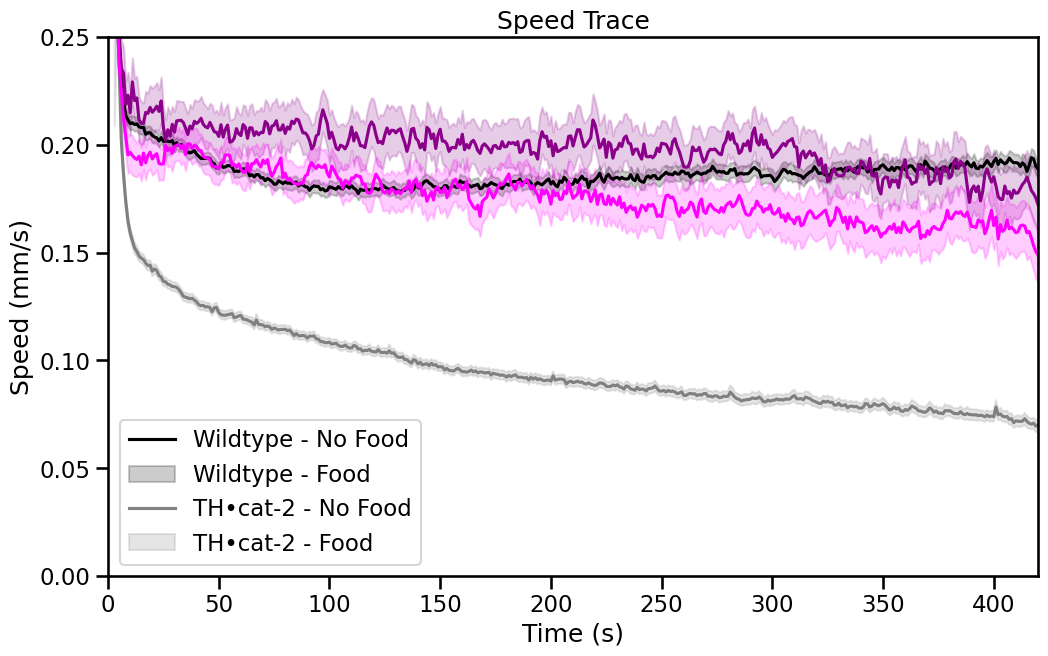

In [58]:
# Setting viewing range for your graph
top = 0.25
bottom = 0
left = 0
right = 420

# Set specifications for graph
sns.set_context("talk")
plt.figure(linewidth = 2.5)
plt.figure(figsize = (12, 7))
plt.gca().xaxis.grid(False)

# Specify data and colours to be used
ax = sns.lineplot(x = "time_bin",
                  y = "speed",
                  # data = TotalConcatenated,  # <----- uncomment and comment row below if using all data
                  data = TotalN2cat2,
                  hue = 'Strain',
                  palette = ['black',
                             'grey',
                             '#8B008B',
                             '#FF00FF',
                            ],
                 legend=False)
# Specify location for legend
plt.legend(title='', loc = 'lower left',labels = ['Wildtype - No Food', 'Wildtype - Food', 'TH•cat-2 - No Food', 'TH•cat-2 - Food'])


# Specify labels
plt.xlabel("Time (s)")
plt.ylabel("Speed (mm/s)")
plt.title("Speed Trace")

# Specify viewing range using variables at top of cell
plt.ylim(top = top)
plt.ylim(bottom = bottom)
plt.xlim(left= left)
plt.xlim(right = right)

# # Add horizontal lines to visualize mean speed of each strain and condition (comment out if using more than N2 & CB1112)
# # If keeping uncommented, may need to adjust indexing to calculate proper speeds
# plt.axhline(y = isinlist['speed'][0], color = 'black', linestyle = ':', alpha = 0.5)
# plt.axhline(y = isinlist['speed'][1], color = 'grey', linestyle = ':', alpha = 0.5)
# plt.axhline(y = isinlist['speed'][2], color = '#FF00FF', linestyle = ':', alpha = 0.5)
# plt.axhline(y = isinlist['speed'][3], color = '#8B008B', linestyle = ':', alpha = 0.5)

# # Add annotations to show mean speed of each strain and condition
# # Same caution as previous step regarding proper speeds
# ax.annotate(f" M = {round(isinlist['speed'][0], 3)}",
#             xy = (420, isinlist['speed'][0]),
#             xytext = (420, isinlist['speed'][0]),
#             color = 'black', size = 14)
# ax.annotate(f" M = {round(isinlist['speed'][1], 3)}",
#             xy = (420, isinlist['speed'][1] - 0.003),
#             xytext = (420, isinlist['speed'][1] - 0.003),
#             color = 'grey', size = 14)
# ax.annotate(f" M = {round(isinlist['speed'][2], 3)}",
#             xy = (420, isinlist['speed'][2] - 0.003),
#             xytext = (420, isinlist['speed'][2] - 0.003),
#             color = '#FF00FF', size = 14)
# ax.annotate(f" M = {round(isinlist['speed'][3], 3)}",
#             xy = (420, isinlist['speed'][3] - 0.005),
#             xytext = (420, isinlist['speed'][3] - 0.007),
#             color = '#8B008B', size = 14)



# Save figure to current working directory
plt.savefig(f'Speed_Trace_{left}to{right}s_legend.jpg', format = 'jpg', dpi = 450, bbox_inches='tight')

plt.show()

# 4 - Generate OffFood/OnFood comparison bar plots

## 4.1 - BSR bar plots (difference of differences and difference of percent change)

### 4.1.1 - First, take data only from the time in the experiment(s) you want to analyze, and find the average speed for each genotype and treatment

In [89]:
# print(TotalConcatenated.head(1))

start = 100  # <----- set the start time of the range
point = 400  # <----- set the end time of your range

# Take data between specified time points
chunkeddata0 = TotalConcatenated[TotalConcatenated["time"] >= start]
chunkeddata = chunkeddata0[chunkeddata0["time"] <= point]

# Take mean of all measures for each worm
chunkeddata_mean = chunkeddata.groupby(["Strain", "worm"], as_index = False).mean()

# Split `Strain` column into `Genotype` and `Treatment` columns
chunkeddata_mean[['Genotype', 'Treatment']] = chunkeddata_mean['Strain'].str.split('_', 1, expand=True)

# Select only the specified columns from previous result (others not important for BSR score)
worm_avg_speed = chunkeddata_mean[['Genotype', 'Treatment', 'Strain', 'speed']]
print(len(worm_avg_speed.Genotype.unique()))

# Take mean speed for each genotype and treatment (should result in 2 rows for each genotype - 1 for each condition)
avg_speed = worm_avg_speed.groupby(["Strain", 'Treatment', 'Genotype'], as_index = False).mean()
print(avg_speed)
print(len(avg_speed.Genotype.unique()))
# avg_speed.to_csv("avg_speed.csv")

58
                       Strain Treatment          Genotype     speed
0    C29E4.10(ok2752)_OffFood   OffFood  C29E4.10(ok2752)  0.146825
1     C29E4.10(ok2752)_OnFood    OnFood  C29E4.10(ok2752)  0.063348
2      F53B2.5(ok226)_OffFood   OffFood    F53B2.5(ok226)  0.122221
3       F53B2.5(ok226)_OnFood    OnFood    F53B2.5(ok226)  0.062077
4                  N2_OffFood   OffFood                N2  0.193063
..                        ...       ...               ...       ...
109      unc-10(ad591)_OnFood    OnFood     unc-10(ad591)  0.053308
110      vps-35(hu68)_OffFood   OffFood      vps-35(hu68)  0.068205
111       vps-35(hu68)_OnFood    OnFood      vps-35(hu68)  0.053125
112    vps-35(ok1880)_OffFood   OffFood    vps-35(ok1880)  0.086613
113     vps-35(ok1880)_OnFood    OnFood    vps-35(ok1880)  0.061525

[114 rows x 4 columns]
58


/var/folders/31/jpj6mpsx60d9829cymplqfsh0000gn/T/ipykernel_42384/2913900164.py:14: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  chunkeddata_mean[['Genotype', 'Treatment']] = chunkeddata_mean['Strain'].str.split('_', 1, expand=True)


### 4.1.2 - Then, calculate the difference in speed between conditions for each genotype (in mm/s), as well as the percent change in speed relative to OffFood speed for each genotype

In [107]:
# avg_speed.to_csv('test_avg_speed.csv')
# avg_speed=avg_speed.replace(to_replace='catp-6(ok34733)',value='catp-6(ok3473)',regex=False)
# avg_speed=avg_speed.replace(to_replace='catp-6(ok347333)',value='catp-6(ok3473)',regex=False)
# avg_speed=avg_speed.replace(to_replace='ok347',value='ok3473',regex=False)
print(avg_speed.Genotype.unique())
print(avg_speed)
names=pd.DataFrame()
names['names']=avg_speed.Genotype.unique()
print(names)
print(len(names))
# names.to_csv('test_names.csv')

['C29E4.10(ok2752)' 'F53B2.5(ok226)' 'N2' 'Y18D10A.22(ok3535)'
 'acr-12(ok367)' 'acr-3(ok2049)' 'acr-6(ok3117)' 'acr-8(ok1240)'
 'bas-1(tm351)' 'cat-1(e1111)' 'cat-1(ok411)' 'cat-2(e1112)'
 'cat-4(e1141)' 'cat-4(tm773)' 'catp-6(ok3473)' 'chd-7(tm6183)'
 'crls-1(tm2542)' 'crls-1(tm2575)' 'djr-1.2(tm1346)' 'dnj-25(ok422)'
 'dop-1(vs101)' 'dop-3(ok295)' 'dop-3(tm1356)' 'gba-3(gk3287)'
 'gba-3(tm3302)' 'gck-3(tm1223)' 'gck-3(tm1296)' 'glo-1(tm15275)'
 'glo-1(tm3240)' 'glo-1(zu391)' 'hipr-1(tm14191)' 'let-19(gk149538)'
 'let-19(os33)' 'lrk-1(tm1898)' 'lrk-1(tm7568)' 'mbk-1(pk1389)'
 'mbl-1(tm1207)' 'mbl-1(tm1277)' 'mex-3(spr-10)' 'mex-3(spr5)'
 'mex-3(spr6)' 'mex-3(spr7)' 'mex-3(spr9)' 'mex-3(zu155)' 'pdr-1(gk448)'
 'pdr-1(tm598)' 'pink-1(ok3538)' 'pink-1(tm1779)' 'rskd-1(gk1208)'
 'set-2(n4589)' 'set-2(ok952)' 'sipa-1(ok879)' 'snb-5(ok1434)'
 'tag-138(gk247)' 'unc-10(ad591)' 'vps-35(hu68)' 'vps-35(ok1880)']
                       Strain Treatment          Genotype     speed
0    C29E4.10(o

In [116]:
# ABSOLUTE DIFFERENCE
# Drop `Strain` and `Treatment` columns, group by `Genotype` (without making index based on `Genotype`)
# Then, for each `Genotype`, subtract OnFood from OffFood speed

print(len(avg_speed))
speed_diff = avg_speed.drop(columns = ["Strain", "Treatment"])
speed_diff = speed_diff.groupby(["Genotype"], as_index = False).diff(periods = -1).dropna()
# print(speed_diff)
print(len(speed_diff))
# rename difference column to 'speed_diff'
speed_diff.columns = ['speed_diff']

print(speed_diff)
# speed_diff.to_csv("test_speed_diff.csv")
# # PERCENT DIFFERENCE
avg_speed['speed_pct_diff'] = avg_speed.groupby('Genotype', as_index = False)['speed'].apply(lambda x: (x - x.shift(-1)) / x)
speed_pct_diff = avg_speed['speed_pct_diff'].dropna()
avg_speed = avg_speed.drop(columns = ['speed_pct_diff'])

print(speed_pct_diff)

# print(avg_speed)

114
57
     speed_diff
0      0.083477
2      0.060144
4      0.094189
6      0.063434
8      0.118068
10     0.063129
12     0.036117
14     0.040994
16     0.027675
18     0.041284
20     0.050080
22     0.018414
24     0.008841
26     0.045322
28     0.030221
30     0.081047
32     0.076334
34     0.084007
36     0.114877
38     0.117736
40     0.126905
42     0.093925
44     0.077665
46     0.073079
48     0.100592
50     0.102350
52     0.114929
54     0.118264
56     0.107432
58     0.044088
60     0.101552
62     0.055498
64     0.161318
66     0.062058
68     0.051566
70     0.085270
72     0.091842
74     0.065198
76     0.086490
78     0.035773
80     0.080047
82     0.054015
84     0.069040
86     0.060222
88     0.096424
90     0.030647
92     0.037308
94     0.019454
96     0.083721
98     0.012592
100    0.088226
102    0.047451
104    0.050572
106    0.094857
108    0.025065
110    0.015080
112    0.025088
0      0.568548
2      0.492094
4      0.487869
6      0.493105
8

/var/folders/31/jpj6mpsx60d9829cymplqfsh0000gn/T/ipykernel_42384/1852856172.py:16: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  avg_speed['speed_pct_diff'] = avg_speed.groupby('Genotype', as_index = False)['speed'].apply(lambda x: (x - x.shift(-1)) / x)


### 4.1.3 - Combine the absolute difference and percent difference data

In [112]:
speed_diff.insert(loc=0,column='Genotype', value=avg_speed['Genotype'].unique())
speed_diff=speed_diff.reset_index(drop=True)
print(speed_diff)

              Genotype     speed
0     C29E4.10(ok2752)  0.083477
1       F53B2.5(ok226)  0.060144
2                   N2  0.094189
3   Y18D10A.22(ok3535)  0.063434
4        acr-12(ok367)  0.118068
5        acr-3(ok2049)  0.063129
6        acr-6(ok3117)  0.036117
7        acr-8(ok1240)  0.040994
8         bas-1(tm351)  0.027675
9         cat-1(e1111)  0.041284
10        cat-1(ok411)  0.050080
11        cat-2(e1112)  0.018414
12        cat-4(e1141)  0.008841
13        cat-4(tm773)  0.045322
14      catp-6(ok3473)  0.030221
15       chd-7(tm6183)  0.081047
16      crls-1(tm2542)  0.076334
17      crls-1(tm2575)  0.084007
18     djr-1.2(tm1346)  0.114877
19       dnj-25(ok422)  0.117736
20        dop-1(vs101)  0.126905
21        dop-3(ok295)  0.093925
22       dop-3(tm1356)  0.077665
23       gba-3(gk3287)  0.073079
24       gba-3(tm3302)  0.100592
25       gck-3(tm1223)  0.102350
26       gck-3(tm1296)  0.114929
27      glo-1(tm15275)  0.118264
28       glo-1(tm3240)  0.107432
29        

In [117]:
all_diff_measures = pd.concat([speed_diff, speed_pct_diff], axis = 1)
print(all_diff_measures)
# all_diff_measures = all_diff_measures.rename(columns = {0: 'speed_pct_diff'})
print(all_diff_measures.info())
print(avg_speed['Genotype'].unique())
print(len(avg_speed['Genotype'].unique()))
# add `Genotype` labels back to speed difference measures so differences can be identified
all_diff_measures.insert(loc = 0, column = 'Genotype', value = avg_speed['Genotype'].unique())
all_diff_measures.reset_index(drop = True)

     speed_diff  speed_pct_diff
0      0.083477        0.568548
2      0.060144        0.492094
4      0.094189        0.487869
6      0.063434        0.493105
8      0.118068        0.573019
10     0.063129        0.357122
12     0.036117        0.255629
14     0.040994        0.292311
16     0.027675        0.158510
18     0.041284        0.547732
20     0.050080        0.299080
22     0.018414        0.088095
24     0.008841        0.060422
26     0.045322        0.264768
28     0.030221        0.369183
30     0.081047        0.540607
32     0.076334        0.439926
34     0.084007        0.504781
36     0.114877        0.642368
38     0.117736        0.620072
40     0.126905        0.580106
42     0.093925        0.472400
44     0.077665        0.478423
46     0.073079        0.513303
48     0.100592        0.561863
50     0.102350        0.638877
52     0.114929        0.718247
54     0.118264        0.670853
56     0.107432        0.666893
58     0.044088        0.414228
60     0

,Genotype,speed_diff,speed_pct_diff
0,C29E4.10(ok2752),0.083477,0.568548
1,F53B2.5(ok226),0.060144,0.492094
2,N2,0.094189,0.487869
3,Y18D10A.22(ok3535),0.063434,0.493105
4,acr-12(ok367),0.118068,0.573019
5,acr-3(ok2049),0.063129,0.357122
6,acr-6(ok3117),0.036117,0.255629
7,acr-8(ok1240),0.040994,0.292311
8,bas-1(tm351),0.027675,0.158510
9,cat-1(e1111),0.041284,0.547732


### 4.1.4 - Calculate BSR score using both methods (difference of differences & difference of percent change)

In [118]:
# # find N2 speed differences
# print(all_diff_measures.iloc[0, 1])
# print(all_diff_measures.iloc[0, 2])

# calculate BSR score using difference of differences
all_diff_measures['Score_diff_of_diff'] = all_diff_measures['speed_diff'] - all_diff_measures.iloc[2,1]
all_diff_measures['Score_diff_of_pct_diff'] = all_diff_measures['speed_pct_diff'] - all_diff_measures.iloc[2,2]

print(all_diff_measures)

               Genotype  speed_diff  speed_pct_diff  Score_diff_of_diff  \
0      C29E4.10(ok2752)    0.083477        0.568548           -0.010712   
2        F53B2.5(ok226)    0.060144        0.492094           -0.034045   
4                    N2    0.094189        0.487869            0.000000   
6    Y18D10A.22(ok3535)    0.063434        0.493105           -0.030755   
8         acr-12(ok367)    0.118068        0.573019            0.023879   
10        acr-3(ok2049)    0.063129        0.357122           -0.031060   
12        acr-6(ok3117)    0.036117        0.255629           -0.058072   
14        acr-8(ok1240)    0.040994        0.292311           -0.053195   
16         bas-1(tm351)    0.027675        0.158510           -0.066514   
18         cat-1(e1111)    0.041284        0.547732           -0.052905   
20         cat-1(ok411)    0.050080        0.299080           -0.044110   
22         cat-2(e1112)    0.018414        0.088095           -0.075776   
24         cat-4(e1141)  

### 4.1.5 - Make separate dataframe for each method of BSR calculation, and sort by ascending BSR score

In [119]:
# DIFFERENCE OF DIFFERENCES
speed_diff_sorted = all_diff_measures.sort_values(by = ["Score_diff_of_diff"]).drop(columns = ['speed_pct_diff',
                                                                                               'Score_diff_of_pct_diff'])
speed_diff_sorted = speed_diff_sorted.reset_index(drop = True)
print(speed_diff_sorted)

# DIFFERENCE OF PERCENT CHANGE
speed_pct_diff_sorted = all_diff_measures.sort_values(by = ["Score_diff_of_pct_diff"]).drop(columns = ['speed_diff',
                                                                                                       'Score_diff_of_diff'])
speed_pct_diff_sorted = speed_pct_diff_sorted.reset_index(drop = True)
print(speed_pct_diff_sorted)

              Genotype  speed_diff  Score_diff_of_diff
0         cat-4(e1141)    0.008841           -0.085349
1         set-2(n4589)    0.012592           -0.081597
2         vps-35(hu68)    0.015080           -0.079110
3         cat-2(e1112)    0.018414           -0.075776
4       pink-1(tm1779)    0.019454           -0.074736
5        unc-10(ad591)    0.025065           -0.069124
6       vps-35(ok1880)    0.025088           -0.069101
7         bas-1(tm351)    0.027675           -0.066514
8       catp-6(ok3473)    0.030221           -0.063968
9         pdr-1(tm598)    0.030647           -0.063542
10         mex-3(spr5)    0.035773           -0.058417
11       acr-6(ok3117)    0.036117           -0.058072
12      pink-1(ok3538)    0.037308           -0.056881
13       acr-8(ok1240)    0.040994           -0.053195
14        cat-1(e1111)    0.041284           -0.052905
15        glo-1(zu391)    0.044088           -0.050101
16        cat-4(tm773)    0.045322           -0.048868
17       s

In [15]:
# NOT SURE WHAT THE USE OF THIS IS - BEN

# avg_speed["new"] = range(1, len(avg_speed) + 1)
# avg_speed.loc[avg_speed.index == 4, 'new'] = 0
# avg_speed.loc[avg_speed.index == 4, 'new'] = 0
# print(avg_speed)
# # avg_speed.sort_values("new").drop('new', axis=1)

## 4.1.6 - Making the bar plot (difference of differences)

<Figure size 640x480 with 0 Axes>

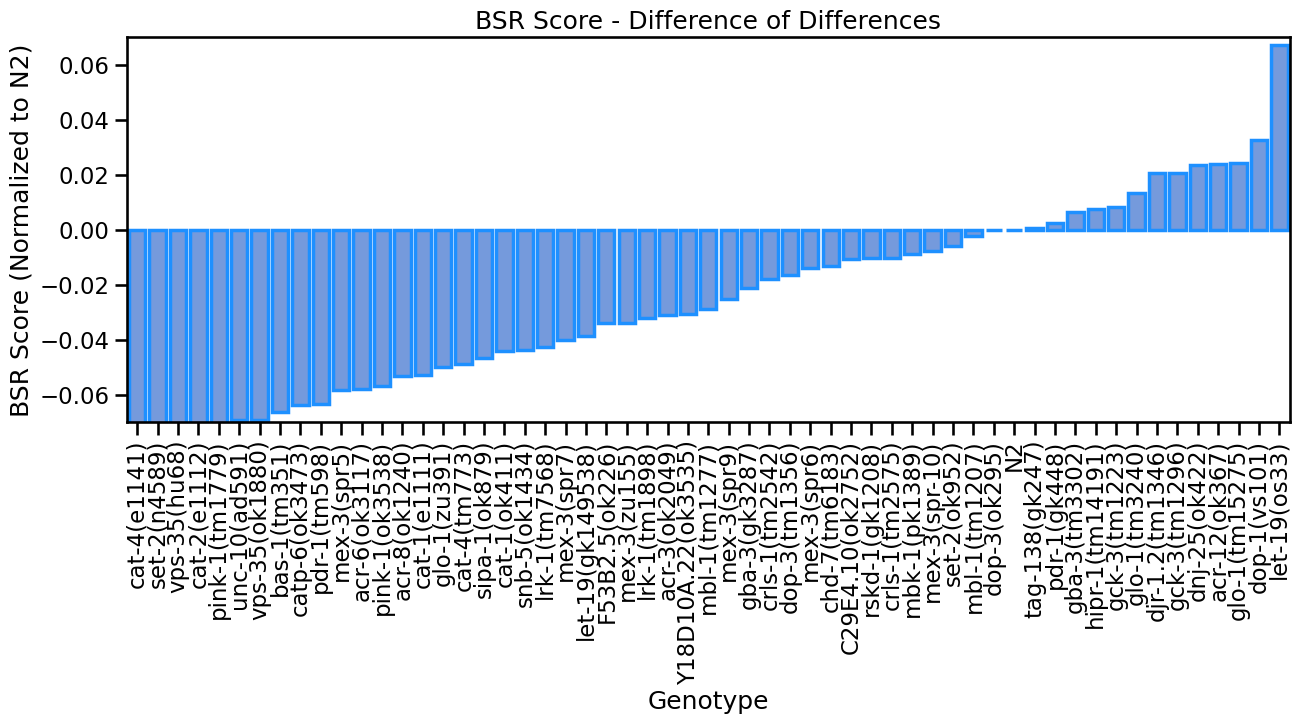

In [120]:
Title = "BSR Score - Difference of Differences"  # <---------------- Input Here -----------------
sns.set_context("talk")
plt.figure(linewidth = 1)
plt.figure(figsize = (15, 5))
plt.gca().xaxis.grid(False)
ax = sns.barplot(x = 'Genotype', 
             y = 'Score_diff_of_diff', 
             data = speed_diff_sorted,  # <--------------- Input Here -------------
             color = 'CornflowerBlue',
             edgecolor = "DodgerBlue",
             linewidth = 2.5,
#              seed=5,
#              ci = 95, # 'sd' for SD, '68' for SEM
#              palette = ['grey',
#                         'black'
#                        ]
                )
plt.xlabel("Genotype")
plt.xticks(rotation = 90)
plt.ylabel("BSR Score (Normalized to N2)")
# plt.ylim(top = 0.1)
# plt.ylim(bottom = -0.1)
plt.ylim(top = 0.07)
plt.ylim(bottom = -0.07)
plt.title(Title)
# plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
plt.savefig(f'{Title}.jpg', format = 'jpg', dpi = 450, bbox_inches = 'tight')
plt.show()

## 4.1.7 - Making the bar plot (difference of percent change)

<Figure size 640x480 with 0 Axes>

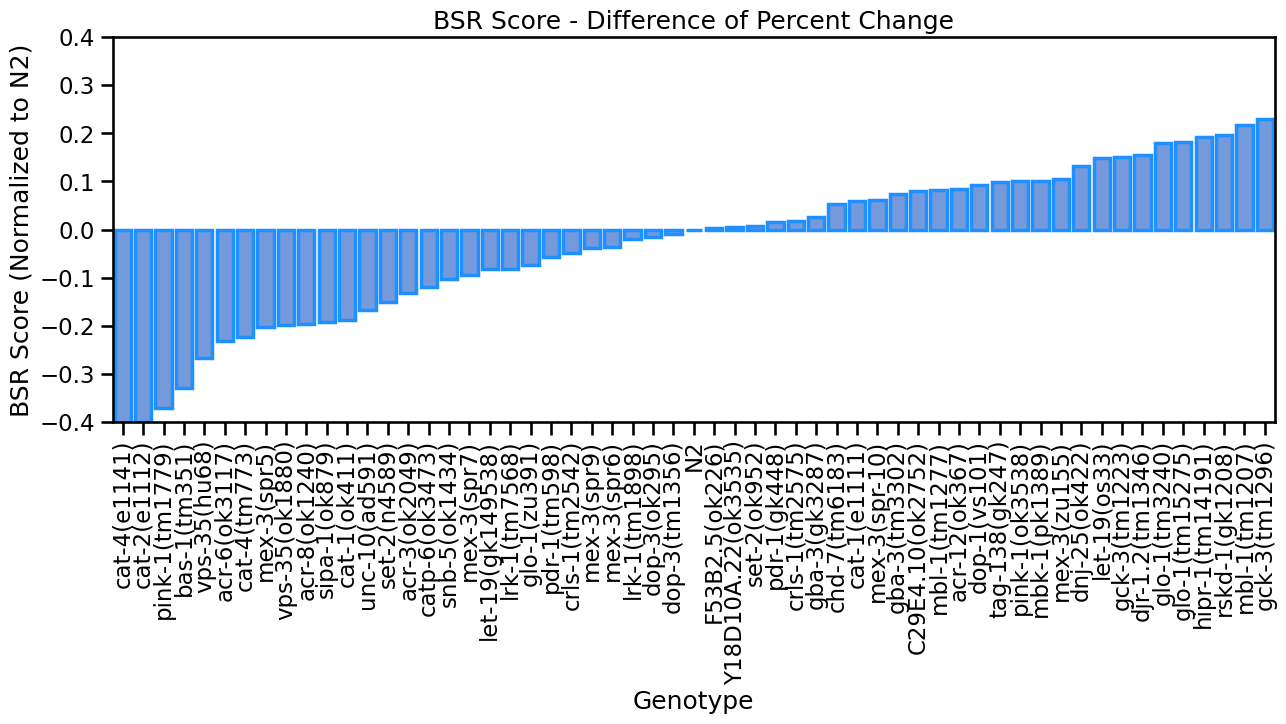

In [121]:
Title = "BSR Score - Difference of Percent Change"  # <---------------- Input Here -----------------
sns.set_context("talk")
plt.figure(linewidth = 1)
plt.figure(figsize = (15, 5))
plt.gca().xaxis.grid(False)
ax = sns.barplot(x = 'Genotype', 
             y = 'Score_diff_of_pct_diff', 
             data = speed_pct_diff_sorted,  # <--------------- Input Here -------------
             color = 'CornflowerBlue',
             edgecolor = "DodgerBlue",
             linewidth = 2.5,
#              seed=5,
#              ci = 95, # 'sd' for SD, '68' for SEM
#              palette = ['grey',
#                         'black'
#                        ]
                )
plt.xlabel("Genotype")
plt.xticks(rotation = 90)
plt.ylabel("BSR Score (Normalized to N2)")
plt.ylim(top = 0.4)
plt.ylim(bottom = -0.4)
plt.title(Title)
# plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
plt.savefig(f'{Title}.jpg', format = 'jpg', dpi = 450, bbox_inches = 'tight')
plt.show()

## 4.2 - Generic differences of differences script (for any behavioural phenotype)

Very little commentary here, as code is similar to that for BSR score apart from inputting behavioural phenotype of interest

In [124]:
# avg_speed=avg_speed.replace(to_replace='catp-6(ok34733)',value='catp-6(ok3473)',regex=False)
# avg_speed=avg_speed.replace(to_replace='catp-6(ok347333)',value='catp-6(ok3473)',regex=False)
# avg_speed=avg_speed.replace(to_replace='ok347',value='ok3473',regex=False)
TotalConcatenated=TotalConcatenated.replace(to_replace='catp-6(ok347)_OnFood',value='catp-6(ok3473)_OnFood',regex=False)
TotalConcatenated=TotalConcatenated.replace(to_replace='catp-6(ok347)_OffFood',value='catp-6(ok3473)_OffFood',regex=False)
print(TotalConcatenated)

         Unnamed: 0  time_bin  worm        time     speed          x  \
0                 0       3.0     1    2.666125  0.352013  21.461862   
1                 1       3.0     8    2.546000  0.395982  27.712055   
2                 2       3.0    85    2.744000  0.324933  22.659617   
3                 3       3.0   165    2.776800  0.280820  19.180400   
4                 4       3.0   249    2.817250  0.216575  19.060475   
...             ...       ...   ...         ...       ...        ...   
4761605       34533     420.0   224  419.514417  0.144642  26.647400   
4761606       34534     420.0   226  419.514417  0.065600  16.178017   
4761607       34535     420.0   227  419.503545  0.131055  11.395073   
4761608       34536     420.0   231  419.514417  0.161325  17.991025   
4761609       34537     420.0   232  419.514417  0.123725  25.133917   

                 y  angularspeed  pathlength       kink      bias      curve  \
0        21.220437    134.875000    0.125875  82.212500

/var/folders/31/jpj6mpsx60d9829cymplqfsh0000gn/T/ipykernel_42384/641942311.py:10: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  chunkeddata_mean[['Genotype', 'Treatment']] = chunkeddata_mean['Strain'].str.split('_', 1, expand=True)


               Genotype       kink      Score
90         pdr-1(tm598)  -9.511595 -14.250301
60      hipr-1(tm14191)  -5.687998 -10.426704
50        gck-3(tm1223)  -5.187840  -9.926547
52        gck-3(tm1296)  -3.538315  -8.277022
8         acr-12(ok367)  -1.607760  -6.346466
28       catp-6(ok3473)  -1.184157  -5.922863
34       crls-1(tm2575)  -0.913582  -5.652289
56        glo-1(tm3240)  -0.844942  -5.583649
64         let-19(os33)   0.319584  -4.419123
72        mbl-1(tm1207)   0.750514  -3.988193
30        chd-7(tm6183)   0.825129  -3.913578
100        set-2(ok952)   0.993376  -3.745331
6    Y18D10A.22(ok3535)   1.098429  -3.640278
96       rskd-1(gk1208)   1.915413  -2.823294
94       pink-1(tm1779)   2.240634  -2.498073
92       pink-1(ok3538)   2.416762  -2.321944
70        mbk-1(pk1389)   2.448548  -2.290158
38        dnj-25(ok422)   2.481214  -2.257492
80          mex-3(spr6)   2.895587  -1.843120
48        gba-3(tm3302)   3.234995  -1.503712
74        mbl-1(tm1277)   3.245165

<Figure size 640x480 with 0 Axes>

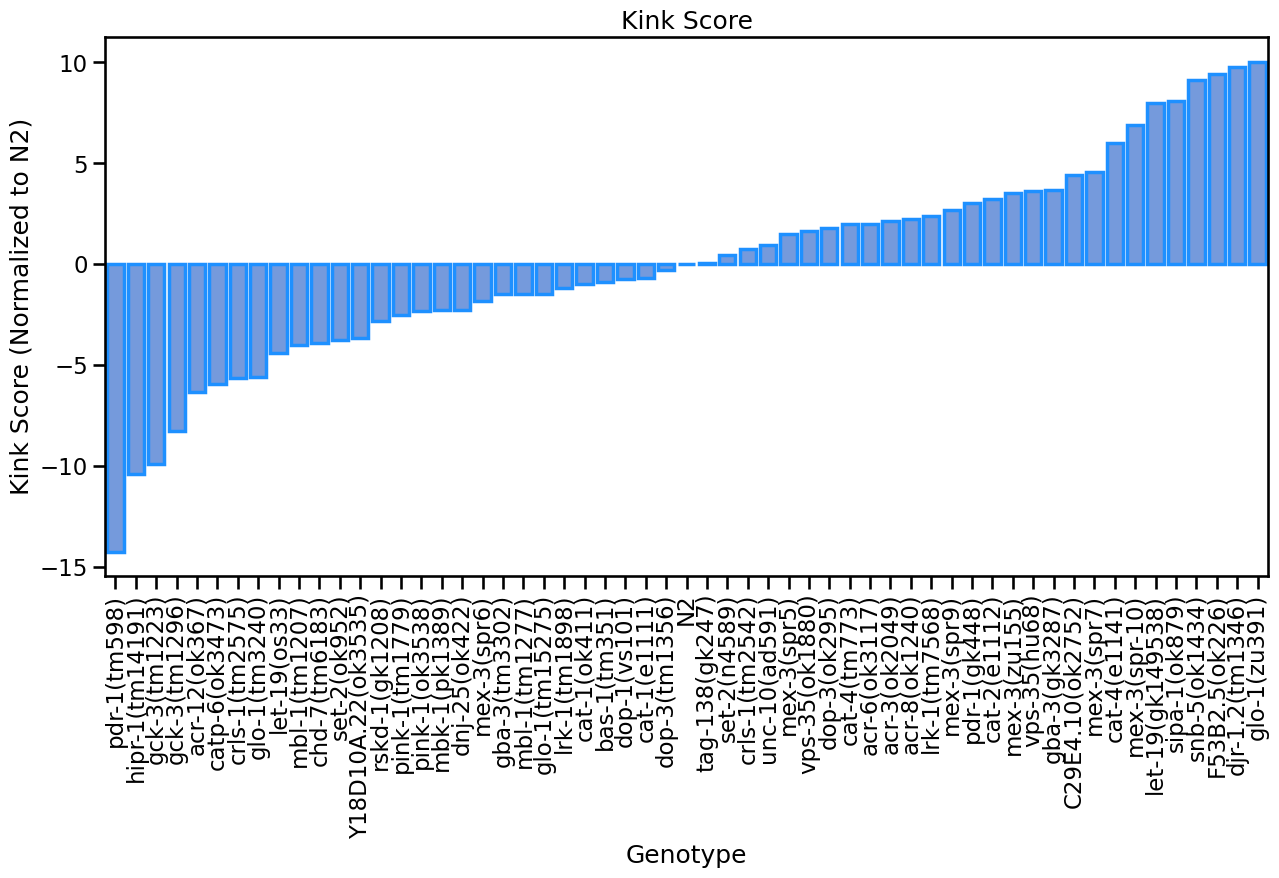

In [150]:
# behavioural_phenotypes = ['speed', 'angularspeed', 'bias', 'curve', 'crab', 'kink']
parameter = 'kink'  # <----- INPUT PHENOTYPE OF INTEREST HERE

start = 100 #<----- set the start time of the range
point = 400 #<------- set the end time of your range

chunkeddata0 = TotalConcatenated[TotalConcatenated["time"] >= start]
chunkeddata = chunkeddata0[chunkeddata0["time"] <= point]
chunkeddata_mean = chunkeddata.groupby(["Strain","worm"], as_index=False).mean()
chunkeddata_mean[['Genotype', 'Treatment']] = chunkeddata_mean['Strain'].str.split('_', 1, expand=True)
worm_avg_parameter = chunkeddata_mean[['Genotype', 'Treatment', 'Strain', parameter]]
avg_parameter = worm_avg_parameter.groupby(["Strain", 'Treatment', 'Genotype'], as_index=False).mean()
# print(avg_parameter)

# avg_parameter.to_csv("avg_parameter.csv")

parameter_diff = avg_parameter.drop(columns=["Strain", "Treatment"]).groupby("Genotype", as_index = False).diff(periods = -1).dropna()
parameter_diff.insert(loc = 0, column='Genotype', value = avg_parameter['Genotype'].unique())
parameter_diff.reset_index(drop = True)
# print(parameter_diff)
# print(parameter_diff.iloc[0,1])
parameter_diff['Score'] = parameter_diff[parameter] - parameter_diff.iloc[2,1]
parameter_diff = parameter_diff.sort_values(by = ["Score"])
print(parameter_diff)
kink_score=parameter_diff
#################

# print(parameter_diff.iloc[0,1])

#################

# AGAIN, NOT SURE WHAT THIS IS FOR - BEN
# avg_parameter["new"] = range(1,len(avg_parameter) + 1)
# avg_parameter.loc[avg_parameter.index == 4, 'new'] = 0
# avg_parameter.loc[avg_parameter.index == 4, 'new'] = 0
# print(avg_parameter)
# # avg_parameter.sort_values("new").drop('new', axis=1)

#################

Title = f"{parameter.capitalize()} Score"  # <---------------- Input Here -----------------
sns.set_context("talk")
plt.figure(linewidth = 1)
plt.figure(figsize = (15, 7))
plt.gca().xaxis.grid(False)
ax = sns.barplot(x = "Genotype",
                 y = 'Score',
                 data = parameter_diff,  # <--------------- Input Here -------------
                 color = 'CornflowerBlue',
                 edgecolor = "DodgerBlue",
                 linewidth = 2.5,
                )

plt.xlabel("Genotype")
plt.xticks(rotation = 90)
plt.ylabel(f"{parameter.capitalize()} Score (Normalized to N2)")

# plt.ylim(top = 0.1)
# plt.ylim(bottom = -0.1)
plt.title(Title)
# plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)

plt.savefig(f'{Title}.jpg', format = 'jpg', dpi = 450, bbox_inches = 'tight')

plt.show()

# 5 - Phenotype Heatmap

## 5.1 - Calculate difference of differences scores for all behavioural phenotypes

In [141]:
print(all_strains)

              Genotype
0     C29E4.10(ok2752)
1       F53B2.5(ok226)
2                   N2
3   Y18D10A.22(ok3535)
4        acr-12(ok367)
5        acr-3(ok2049)
6        acr-6(ok3117)
7        acr-8(ok1240)
8         bas-1(tm351)
9         cat-1(e1111)
10        cat-1(ok411)
11        cat-2(e1112)
12        cat-4(e1141)
13        cat-4(tm773)
14      catp-6(ok3473)
15       chd-7(tm6183)
16      crls-1(tm2542)
17      crls-1(tm2575)
18     djr-1.2(tm1346)
19       dnj-25(ok422)
20        dop-1(vs101)
21        dop-3(ok295)
22       dop-3(tm1356)
23       gba-3(gk3287)
24       gba-3(tm3302)
25       gck-3(tm1223)
26       gck-3(tm1296)
27      glo-1(tm15275)
28       glo-1(tm3240)
29        glo-1(zu391)
30     hipr-1(tm14191)
31    let-19(gk149538)
32        let-19(os33)
33       lrk-1(tm1898)
34       lrk-1(tm7568)
35       mbk-1(pk1389)
36       mbl-1(tm1207)
37       mbl-1(tm1277)
38       mex-3(spr-10)
39         mex-3(spr5)
40         mex-3(spr6)
41         mex-3(spr7)
42         

In [152]:
print(kink_score)

               Genotype       kink      Score
90         pdr-1(tm598)  -9.511595 -14.250301
60      hipr-1(tm14191)  -5.687998 -10.426704
50        gck-3(tm1223)  -5.187840  -9.926547
52        gck-3(tm1296)  -3.538315  -8.277022
8         acr-12(ok367)  -1.607760  -6.346466
28       catp-6(ok3473)  -1.184157  -5.922863
34       crls-1(tm2575)  -0.913582  -5.652289
56        glo-1(tm3240)  -0.844942  -5.583649
64         let-19(os33)   0.319584  -4.419123
72        mbl-1(tm1207)   0.750514  -3.988193
30        chd-7(tm6183)   0.825129  -3.913578
100        set-2(ok952)   0.993376  -3.745331
6    Y18D10A.22(ok3535)   1.098429  -3.640278
96       rskd-1(gk1208)   1.915413  -2.823294
94       pink-1(tm1779)   2.240634  -2.498073
92       pink-1(ok3538)   2.416762  -2.321944
70        mbk-1(pk1389)   2.448548  -2.290158
38        dnj-25(ok422)   2.481214  -2.257492
80          mex-3(spr6)   2.895587  -1.843120
48        gba-3(tm3302)   3.234995  -1.503712
74        mbl-1(tm1277)   3.245165

In [231]:
behavioural_phenotypes = ['speed', 'angularspeed', 'bias', 'curve', 'crab', 'kink']
# print(all_strains)

def differences_of_differences(start, point, df):
    chunkeddata0 = df[df["time"] >= start]
    chunkeddata = chunkeddata0[chunkeddata0["time"] <= point]
    chunkeddata_mean = chunkeddata.groupby(["Strain", "worm"], as_index=False).mean()
    chunkeddata_mean[['Genotype', 'Treatment']] = chunkeddata_mean['Strain'].str.split('_', 1, expand=True)
    all_scores = all_strains
    for parameter in behavioural_phenotypes:
        worm_avg_parameter = chunkeddata_mean[['Genotype', 'Treatment', 'Strain', parameter]]
        avg_parameter = worm_avg_parameter.groupby(["Strain", 'Treatment', 'Genotype'], as_index=False).mean()
        # print(avg_parameter)

        # avg_parameter.to_csv("avg_parameter.csv")

        parameter_diff = avg_parameter.drop(columns=["Strain", "Treatment"]).groupby("Genotype", as_index=False).diff(periods=-1).dropna()
        parameter_diff.insert(loc=0, column='Genotype', value = avg_parameter['Genotype'].unique())
        parameter_diff.reset_index(drop=True)
        # print(parameter_diff)
        # print(parameter_diff.iloc[0,1])
        parameter_diff['Score'] = parameter_diff[parameter] - parameter_diff.iloc[2,1]
        # parameter_diff = parameter_diff.sort_values(by = ["Score"])
        parameter_diff = parameter_diff.drop(columns = [parameter])
        parameter_diff = parameter_diff.rename(columns = {'Score':parameter})
        parameter_diff = parameter_diff.reset_index(drop = True)
        # print(parameter_diff)
        all_scores = all_scores.join(parameter_diff.iloc[:,1])
    all_scores = all_scores.set_index("Genotype")
    return(all_scores)

differences_of_differences(300, 400, TotalConcatenated)

/var/folders/31/jpj6mpsx60d9829cymplqfsh0000gn/T/ipykernel_42384/2590596170.py:8: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  chunkeddata_mean[['Genotype', 'Treatment']] = chunkeddata_mean['Strain'].str.split('_', 1, expand=True)


,speed,angularspeed,bias,curve,crab,kink
Genotype,,,,,,
C29E4.10(ok2752),-0.007739,0.193162,0.079408,3.197204,-0.000580,2.849711
F53B2.5(ok226),-0.040882,2.181807,-0.148904,3.033286,-0.002221,12.075229
N2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Y18D10A.22(ok3535),-0.030307,-4.382697,0.415849,0.190697,-0.005933,-4.350432
acr-12(ok367),0.028552,4.286592,0.193260,-0.421192,0.005001,-7.028911
acr-3(ok2049),-0.036642,1.651051,-0.147789,-1.953897,-0.000009,2.952159
acr-6(ok3117),-0.034028,-2.801141,0.314293,1.883260,-0.003896,2.360939
acr-8(ok1240),-0.053138,-3.449952,-0.018026,0.191421,-0.004806,-1.124673
bas-1(tm351),-0.070978,-3.358234,-0.153019,0.330519,-0.006386,1.501968


### 5.1.1 - Use function defined above to store difference of difference dataframe in a new variable

In [153]:
PD_gene_behavioural_scores = differences_of_differences(100, 400, TotalConcatenated)
PD_gene_behavioural_scores = PD_gene_behavioural_scores.dropna().sort_index()
print(PD_gene_behavioural_scores)

/var/folders/31/jpj6mpsx60d9829cymplqfsh0000gn/T/ipykernel_42384/4024866155.py:8: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  chunkeddata_mean[['Genotype', 'Treatment']] = chunkeddata_mean['Strain'].str.split('_', 1, expand=True)


                       speed  angularspeed      bias     curve      crab  \
Genotype                                                                   
C29E4.10(ok2752)   -0.010712      0.465778  0.123292  3.518549 -0.000420   
F53B2.5(ok226)     -0.034045      2.365377 -0.156345  1.650354 -0.002656   
N2                  0.000000      0.000000  0.000000  0.000000  0.000000   
Y18D10A.22(ok3535) -0.030755     -3.885597  0.362393 -0.011351 -0.004849   
acr-12(ok367)       0.023879      3.666346  0.079246 -0.397139  0.003851   
acr-3(ok2049)      -0.031060      1.350958 -0.154088 -1.662927 -0.000546   
acr-6(ok3117)      -0.058072     -4.051642  0.163541  0.660681 -0.005807   
acr-8(ok1240)      -0.053195     -2.897834 -0.014442  0.876403 -0.004482   
bas-1(tm351)       -0.066514     -4.690872 -0.019513  0.237527 -0.007215   
cat-1(e1111)       -0.052905     -4.181707  0.328870  1.590197 -0.007278   
cat-1(ok411)       -0.044110     -2.689756  0.248423 -1.542132 -0.005811   
cat-2(e1112)

### 5.1.2 - Standardize and normalize the difference of difference scores

In [155]:
PD_gene_behavioural_scores_standardize = (PD_gene_behavioural_scores - PD_gene_behavioural_scores.mean())/PD_gene_behavioural_scores.std()
print(PD_gene_behavioural_scores_standardize)

PD_gene_behavioural_scores_normalize = PD_gene_behavioural_scores_standardize - PD_gene_behavioural_scores_standardize[PD_gene_behavioural_scores_standardize.index == 'N2'].squeeze()
print(PD_gene_behavioural_scores_normalize)
PD_gene_behavioural_scores_normalize = PD_gene_behavioural_scores_normalize.drop(index = 'N2')
print(PD_gene_behavioural_scores_normalize)

                       speed  angularspeed      bias     curve      crab  \
Genotype                                                                   
C29E4.10(ok2752)    0.443206      0.563948  0.220131  1.434002  0.662800   
F53B2.5(ok226)     -0.244442      1.193350 -1.231035  0.526716  0.097503   
N2                  0.758916      0.409620 -0.419687 -0.274776  0.769099   
Y18D10A.22(ok3535) -0.147485     -0.877811  1.460931 -0.280289 -0.457206   
acr-12(ok367)       1.462657      1.624405 -0.008445 -0.467646  1.742979   
acr-3(ok2049)      -0.156481      0.857238 -1.219321 -1.082374  0.631072   
acr-6(ok3117)      -0.952563     -0.932828  0.429000  0.046083 -0.699374   
acr-8(ok1240)      -0.808814     -0.550532 -0.494634  0.150848 -0.364306   
bas-1(tm351)       -1.201355     -1.144626 -0.520950 -0.159422 -1.055510   
cat-1(e1111)       -0.800283     -0.975923  1.286969  0.497501 -1.071458   
cat-1(ok411)       -0.541056     -0.481588  0.869490 -1.023710 -0.700501   
cat-2(e1112)

## 5.2 - Calculate, standardize, and normalize t-scores for all baseline behavioural and morphological phenotypes

### 5.2.1 - Read in and tidy data (same data as used previously)

In [158]:
print(chunkeddata_mean)

                         Strain  worm    Unnamed: 0  time_bin        time  \
0      C29E4.10(ok2752)_OffFood     1   8854.590000     250.5  250.000437   
1      C29E4.10(ok2752)_OffFood     2   7978.856000     225.5  224.999992   
2      C29E4.10(ok2752)_OffFood     6   6671.028249     189.0  188.497441   
3      C29E4.10(ok2752)_OffFood     7   8857.013333     250.5  250.002214   
4      C29E4.10(ok2752)_OffFood     8   8858.013333     250.5  250.000127   
...                         ...   ...           ...       ...         ...   
29851     vps-35(ok1880)_OnFood   229  20431.105263     249.0  248.502338   
29852     vps-35(ok1880)_OnFood   230  24424.184615     293.0  292.495707   
29853     vps-35(ok1880)_OnFood   231  28208.280000     338.0  337.503083   
29854     vps-35(ok1880)_OnFood   232  28209.280000     338.0  337.504033   
29855     vps-35(ok1880)_OnFood   233  27334.905405     326.5  325.999168   

          speed          x          y  angularspeed  pathlength       kink 

In [172]:
PD_baseline=TotalConcatenated_chunked.drop(columns=['x','y','Unnamed: 0'])
print(PD_baseline)

         time_bin  worm        time     speed  angularspeed  pathlength  \
182609      101.0     2  100.497923  0.381008      8.592308   12.354769   
182610      101.0     5  100.497923  0.051185      1.953846    4.204308   
182611      101.0     7  100.497923  0.096000     16.707692    5.000000   
182612      101.0     8  100.497923  0.175292      7.253846   15.335846   
182613      101.0     9  100.497923  0.198285     26.269231   11.106538   
...           ...   ...         ...       ...           ...         ...   
4760176     400.0   224  399.513917  0.130042      2.791667    9.633167   
4760177     400.0   226  399.473818  0.036882      2.872727    3.148727   
4760178     400.0   227  399.513917  0.069183      3.891667    7.895083   
4760179     400.0   231  399.513917  0.132342      4.516667   12.446417   
4760180     400.0   232  399.513917  0.135517     12.575000   14.681667   

               kink  bias      curve       dir      crab    length   midline  \
182609    52.515385

In [170]:
PD_baseline_mean=PD_baseline.groupby(["Strain", "worm"], as_index=False).mean()
PD_baseline_mean[['Genotype', 'Treatment']] = PD_baseline_mean['Strain'].str.split('_', 1, expand=True)
print(PD_baseline_mean)

                         Strain  worm  time_bin        time     speed  \
0      C29E4.10(ok2752)_OffFood     1     250.5  250.000437  0.158608   
1      C29E4.10(ok2752)_OffFood     2     225.5  224.999992  0.117790   
2      C29E4.10(ok2752)_OffFood     6     189.0  188.497441  0.140437   
3      C29E4.10(ok2752)_OffFood     7     250.5  250.002214  0.114382   
4      C29E4.10(ok2752)_OffFood     8     250.5  250.000127  0.127514   
...                         ...   ...       ...         ...       ...   
29851     vps-35(ok1880)_OnFood   229     249.0  248.502338  0.118773   
29852     vps-35(ok1880)_OnFood   230     293.0  292.495707  0.122036   
29853     vps-35(ok1880)_OnFood   231     338.0  337.503083  0.137469   
29854     vps-35(ok1880)_OnFood   232     338.0  337.504033  0.139475   
29855     vps-35(ok1880)_OnFood   233     326.5  325.999168  0.046806   

       angularspeed  pathlength       kink      bias      curve       dir  \
0         10.941490   31.822024  44.376898  0.

/var/folders/31/jpj6mpsx60d9829cymplqfsh0000gn/T/ipykernel_42384/3133160017.py:2: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  PD_baseline_mean[['Genotype', 'Treatment']] = PD_baseline_mean['Strain'].str.split('_', 1, expand=True)


In [173]:
# PD_baseline = pd.read_csv('baseline_output.csv')
# PD_baseline = PD_baseline.iloc[:, 1:]
# PD_baseline = PD_baseline.drop(columns=["x", "y"])
PD_baseline[['Genotype', 'Treatment']] = PD_baseline['Strain'].str.split('_', expand=True)

print(PD_baseline.head())

/var/folders/31/jpj6mpsx60d9829cymplqfsh0000gn/T/ipykernel_42384/1401283428.py:4: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  PD_baseline[['Genotype', 'Treatment']] = PD_baseline['Strain'].str.split('_', 1, expand=True)


        time_bin  worm        time     speed  angularspeed  pathlength  \
182609     101.0     2  100.497923  0.381008      8.592308   12.354769   
182610     101.0     5  100.497923  0.051185      1.953846    4.204308   
182611     101.0     7  100.497923  0.096000     16.707692    5.000000   
182612     101.0     8  100.497923  0.175292      7.253846   15.335846   
182613     101.0     9  100.497923  0.198285     26.269231   11.106538   

              kink  bias      curve       dir      crab    length   midline  \
182609   52.515385  -1.0  39.184615  0.001462  0.048508  0.836169  1.013838   
182610   31.784615   1.0  37.269231  0.000000  0.006346  0.627231  0.705469   
182611  104.161538   1.0  35.076923  0.000000  0.034923  0.438646  0.667669   
182612   60.638462   1.0  36.530769  0.000000  0.019015  0.867323  1.048992   
182613   47.669231   1.0  37.869231  0.000462  0.024369  0.809585  1.017777   

           width  morphwidth      area      Strain Genotype Treatment  
182609  

### 5.2.2 - Subset the final 100 seconds of the experiment

In [183]:
PD_baseline_last100 = PD_baseline[((PD_baseline.time <= 400) & (PD_baseline.time >= 300))]
PD_baseline_last100 = PD_baseline_last100.reset_index()
PD_baseline_last100 = PD_baseline_last100.dropna().drop(columns=['index'])
# PD_baseline_last100=PD_baseline_last100.replace(to_replace='catp-6(ok347)',value='catp-6(ok3473)',regex=False)
# PD_baseline_last100=PD_baseline_last100.replace(to_replace='catp-6(ok347)_OnFood',value='catp-6(ok3473)_OnFood',regex=False)
# PD_baseline_last100=PD_baseline_last100.replace(to_replace='catp-6(ok347)_OffFood',value='catp-6(ok3473)_OffFood',regex=False)
# avg_speed=avg_speed.replace(to_replace='catp-6(ok347333)',value='catp-6(ok3473)',regex=False)
# avg_speed=avg_speed.replace(to_replace='ok347',value='ok3473',regex=False)


print(PD_baseline_last100)

         time_bin  worm        time     speed  angularspeed  pathlength  \
0           301.0     3  300.494000  0.112342     26.233333    0.979583   
1           301.0     5  300.526636  0.046927      3.281818   13.310182   
2           301.0    13  300.494000  0.201983      2.441667   27.553583   
3           301.0    14  300.494000  0.145258     10.058333   15.159667   
4           301.0    15  300.494000  0.032808     33.133333    0.599417   
...           ...   ...         ...       ...           ...         ...   
1073539     400.0   224  399.513917  0.130042      2.791667    9.633167   
1073540     400.0   226  399.473818  0.036882      2.872727    3.148727   
1073541     400.0   227  399.513917  0.069183      3.891667    7.895083   
1073542     400.0   231  399.513917  0.132342      4.516667   12.446417   
1073543     400.0   232  399.513917  0.135517     12.575000   14.681667   

               kink      bias      curve       dir      crab    length  \
0        105.391667 -1.00

### 5.2.3 - Generate list of all strains in data set

In [184]:
list = PD_baseline_last100["Genotype"].unique()
print(list)

['N2' 'C29E4.10(ok2752)' 'F53B2.5(ok226)' 'Y18D10A.22(ok3535)'
 'acr-12(ok367)' 'acr-3(ok2049)' 'acr-6(ok3117)' 'acr-8(ok1240)'
 'bas-1(tm351)' 'cat-1(e1111)' 'cat-1(ok411)' 'cat-2(e1112)'
 'cat-4(e1141)' 'cat-4(tm773)' 'catp-6(ok3473)' 'chd-7(tm6183)'
 'crls-1(tm2542)' 'crls-1(tm2575)' 'djr-1.2(tm1346)' 'dnj-25(ok422)'
 'dop-1(vs101)' 'dop-3(ok295)' 'dop-3(tm1356)' 'gba-3(gk3287)'
 'gba-3(tm3302)' 'gck-3(tm1223)' 'gck-3(tm1296)' 'glo-1(tm15275)'
 'glo-1(tm3240)' 'glo-1(zu391)' 'hipr-1(tm14191)' 'let-19(gk149538)'
 'let-19(os33)' 'lrk-1(tm1898)' 'lrk-1(tm7568)' 'mbk-1(pk1389)'
 'mbl-1(tm1207)' 'mbl-1(tm1277)' 'mex-3(spr-10)' 'mex-3(spr5)'
 'mex-3(spr6)' 'mex-3(spr7)' 'mex-3(spr9)' 'mex-3(zu155)' 'pdr-1(gk448)'
 'pdr-1(tm598)' 'pink-1(ok3538)' 'pink-1(tm1779)' 'rskd-1(gk1208)'
 'set-2(n4589)' 'set-2(ok952)' 'sipa-1(ok879)' 'snb-5(ok1434)'
 'tag-138(gk247)' 'unc-10(ad591)' 'vps-35(hu68)' 'vps-35(ok1880)']


### 5.2.4 - Separate OffFood and OnFood data for comparison of behaviour within conditions

In [185]:
PD_baseline_last100_OffFood = PD_baseline_last100[PD_baseline_last100["Treatment"] == "OffFood"].dropna().add_suffix('_OffFood')
PD_baseline_last100_OffFood = PD_baseline_last100_OffFood.rename(columns = {'Genotype_OffFood': 'Genotype'})
print(PD_baseline_last100_OffFood)
PD_baseline_last100_OnFood = PD_baseline_last100[PD_baseline_last100["Treatment"] == "OnFood"].dropna().add_suffix('_OnFood')
PD_baseline_last100_OnFood = PD_baseline_last100_OnFood.rename(columns = {'Genotype_OnFood': 'Genotype'})
print(PD_baseline_last100_OnFood)

         time_bin_OffFood  worm_OffFood  time_OffFood  speed_OffFood  \
0                   301.0             3    300.494000       0.112342   
1                   301.0             5    300.526636       0.046927   
2                   301.0            13    300.494000       0.201983   
3                   301.0            14    300.494000       0.145258   
4                   301.0            15    300.494000       0.032808   
...                   ...           ...           ...            ...   
1065519             400.0           303    399.498667       0.042108   
1065520             400.0           304    399.570900       0.019800   
1065521             400.0           305    399.498667       0.079242   
1065522             400.0           307    399.498667       0.056133   
1065523             400.0           310    399.498667       0.017892   

         angularspeed_OffFood  pathlength_OffFood  kink_OffFood  bias_OffFood  \
0                   26.233333            0.979583    1

### 5.2.5 - Generate empty dataframes for each measure of phenotype (scores will be added to these)

In [186]:
PD_gene_baseline_length_T = pd.DataFrame(columns = ["Genotype", "length"])
PD_gene_baseline_midline_T = pd.DataFrame(columns = ["Genotype", "midline"])
PD_gene_baseline_width_T = pd.DataFrame(columns = ["Genotype", "width"])
PD_gene_baseline_morphwidth_T = pd.DataFrame(columns = ["Genotype", "morphwidth"])
PD_gene_baseline_area_T = pd.DataFrame(columns = ["Genotype", "area"])

PD_gene_baseline_speed_T_OffFood = pd.DataFrame(columns = ["Genotype", "speed_OffFood"])
PD_gene_baseline_angularspeed_T_OffFood = pd.DataFrame(columns = ["Genotype", "angularspeed_OffFood"])
PD_gene_baseline_bias_T_OffFood = pd.DataFrame(columns = ["Genotype", "bias_OffFood"])
PD_gene_baseline_curve_T_OffFood = pd.DataFrame(columns = ["Genotype", "curve_OffFood"])
PD_gene_baseline_crab_T_OffFood = pd.DataFrame(columns = ["Genotype", "crab_OffFood"])
PD_gene_baseline_kink_T_OffFood = pd.DataFrame(columns = ["Genotype", "kink_OffFood"])

PD_gene_baseline_speed_T_OnFood = pd.DataFrame(columns = ["Genotype", "speed_OnFood"])
PD_gene_baseline_angularspeed_T_OnFood = pd.DataFrame(columns = ["Genotype", "angularspeed_OnFood"])
PD_gene_baseline_bias_T_OnFood = pd.DataFrame(columns = ["Genotype", "bias_OnFood"])
PD_gene_baseline_curve_T_OnFood = pd.DataFrame(columns = ["Genotype", "curve_OnFood"])
PD_gene_baseline_crab_T_OnFood = pd.DataFrame(columns = ["Genotype", "crab_OnFood"])
PD_gene_baseline_kink_T_OnFood = pd.DataFrame(columns = ["Genotype", "kink_OnFood"])

# print(PD_gene_baseline_midline_T)

### 5.2.6 - Define t-test function

In [180]:
def TTest_Gene(DatasetList, Type, DF_ref, output):
    for a in DatasetList:
        Tstat = ttest_ind(DF_ref[DF_ref.Genotype == a][Type], DF_ref[DF_ref.Genotype == "N2"][Type], equal_var = False)[0]
        row = [a, Tstat]
        output.loc[len(output)] = row
    print(output)

### 5.2.7 - Use `TTest_Gene()` function to generate t-scores for each genotype, measure of phenotype, and condition

In [187]:
# TTest_Gene(PD_baseline_last100["Genotype"].unique(), "length", PD_baseline_last100, PD_gene_baseline_length_T)
# TTest_Gene(PD_baseline_last100["Genotype"].unique(), "midline", PD_baseline_last100, PD_gene_baseline_midline_T)
# TTest_Gene(PD_baseline_last100["Genotype"].unique(), "width", PD_baseline_last100, PD_gene_baseline_width_T)
# TTest_Gene(PD_baseline_last100["Genotype"].unique(), "morphwidth", PD_baseline_last100, PD_gene_baseline_morphwidth_T)
# TTest_Gene(PD_baseline_last100["Genotype"].unique(), "area", PD_baseline_last100, PD_gene_baseline_area_T)

TTest_Gene(PD_baseline_last100["Genotype"].unique(), "speed_OffFood",
           PD_baseline_last100_OffFood, PD_gene_baseline_speed_T_OffFood)
TTest_Gene(PD_baseline_last100["Genotype"].unique(), "angularspeed_OffFood",
           PD_baseline_last100_OffFood, PD_gene_baseline_angularspeed_T_OffFood)
TTest_Gene(PD_baseline_last100["Genotype"].unique(), "bias_OffFood",
           PD_baseline_last100_OffFood, PD_gene_baseline_bias_T_OffFood)
TTest_Gene(PD_baseline_last100["Genotype"].unique(), "curve_OffFood",
           PD_baseline_last100_OffFood, PD_gene_baseline_curve_T_OffFood)
TTest_Gene(PD_baseline_last100["Genotype"].unique(), "crab_OffFood",
           PD_baseline_last100_OffFood, PD_gene_baseline_crab_T_OffFood)
TTest_Gene(PD_baseline_last100["Genotype"].unique(), "kink_OffFood",
           PD_baseline_last100_OffFood, PD_gene_baseline_kink_T_OffFood)

TTest_Gene(PD_baseline_last100["Genotype"].unique(), "speed_OnFood",
           PD_baseline_last100_OnFood, PD_gene_baseline_speed_T_OnFood)
TTest_Gene(PD_baseline_last100["Genotype"].unique(), "angularspeed_OnFood",
           PD_baseline_last100_OnFood, PD_gene_baseline_angularspeed_T_OnFood)
TTest_Gene(PD_baseline_last100["Genotype"].unique(), "bias_OnFood",
           PD_baseline_last100_OnFood, PD_gene_baseline_bias_T_OnFood)
TTest_Gene(PD_baseline_last100["Genotype"].unique(), "curve_OnFood",
           PD_baseline_last100_OnFood, PD_gene_baseline_curve_T_OnFood)
TTest_Gene(PD_baseline_last100["Genotype"].unique(), "crab_OnFood",
           PD_baseline_last100_OnFood, PD_gene_baseline_crab_T_OnFood)
TTest_Gene(PD_baseline_last100["Genotype"].unique(), "kink_OnFood",
           PD_baseline_last100_OnFood, PD_gene_baseline_kink_T_OnFood)

              Genotype  speed_OffFood
0                   N2       0.000000
1     C29E4.10(ok2752)     -39.596125
2       F53B2.5(ok226)     -50.897369
3   Y18D10A.22(ok3535)     -73.593994
4        acr-12(ok367)      20.350617
5        acr-3(ok2049)      -7.246292
6        acr-6(ok3117)     -89.438005
7        acr-8(ok1240)     -54.375145
8         bas-1(tm351)     -17.844158
9         cat-1(e1111)    -156.389876
10        cat-1(ok411)     -35.901804
11        cat-2(e1112)      -0.083642
12        cat-4(e1141)     -26.753033
13        cat-4(tm773)     -36.915828
14      catp-6(ok3473)    -127.391213
15       chd-7(tm6183)     -43.609987
16      crls-1(tm2542)     -18.708337
17      crls-1(tm2575)     -32.459286
18     djr-1.2(tm1346)     -16.314944
19       dnj-25(ok422)       6.099015
20        dop-1(vs101)      -5.214501
21        dop-3(ok295)      -8.766146
22       dop-3(tm1356)     -31.847339
23       gba-3(gk3287)     -50.348937
24       gba-3(tm3302)     -17.628563
25       gck

              Genotype  crab_OffFood
0                   N2      0.000000
1     C29E4.10(ok2752)    -14.684602
2       F53B2.5(ok226)    -17.421847
3   Y18D10A.22(ok3535)    -66.017522
4        acr-12(ok367)     44.594259
5        acr-3(ok2049)     22.005781
6        acr-6(ok3117)    -88.220044
7        acr-8(ok1240)    -18.375727
8         bas-1(tm351)    -14.070498
9         cat-1(e1111)   -117.718913
10        cat-1(ok411)    -32.650330
11        cat-2(e1112)     25.652478
12        cat-4(e1141)     -5.364550
13        cat-4(tm773)    -20.006990
14      catp-6(ok3473)    -62.809313
15       chd-7(tm6183)    -93.640356
16      crls-1(tm2542)    -43.909263
17      crls-1(tm2575)    -62.806782
18     djr-1.2(tm1346)    -12.021469
19       dnj-25(ok422)     27.586110
20        dop-1(vs101)    -47.013701
21        dop-3(ok295)    -15.490358
22       dop-3(tm1356)    -20.678448
23       gba-3(gk3287)    -22.553376
24       gba-3(tm3302)    -35.028524
25       gck-3(tm1223)   -120.552231
2

              Genotype  bias_OnFood
0                   N2     0.000000
1     C29E4.10(ok2752)   -17.310061
2       F53B2.5(ok226)    -8.120512
3   Y18D10A.22(ok3535)   -37.803306
4        acr-12(ok367)   -39.778493
5        acr-3(ok2049)    21.416052
6        acr-6(ok3117)   -28.191194
7        acr-8(ok1240)     5.502644
8         bas-1(tm351)    16.369983
9         cat-1(e1111)  -167.676086
10        cat-1(ok411)   -48.015927
11        cat-2(e1112)    -6.629063
12        cat-4(e1141)   -27.019384
13        cat-4(tm773)    24.402791
14      catp-6(ok3473)   -47.888449
15       chd-7(tm6183)   -46.068766
16      crls-1(tm2542)    -8.772971
17      crls-1(tm2575)   -29.116048
18     djr-1.2(tm1346)   -43.179688
19       dnj-25(ok422)   -50.261048
20        dop-1(vs101)   -66.765539
21        dop-3(ok295)   -30.947271
22       dop-3(tm1356)    22.078915
23       gba-3(gk3287)   -20.364989
24       gba-3(tm3302)   -31.676282
25       gck-3(tm1223)   -31.633369
26       gck-3(tm1296)   -47

### 5.2.8 - Combine all dataframes generated in step 5.2.7

In [188]:
# PD_gene_baseline_Tstats = PD_gene_baseline_length_T
# PD_gene_baseline_Tstats = PD_gene_baseline_Tstats.join(PD_gene_baseline_midline_T.iloc[:,1])
# PD_gene_baseline_Tstats = PD_gene_baseline_Tstats.join(PD_gene_baseline_width_T.iloc[:,1])
# PD_gene_baseline_Tstats = PD_gene_baseline_Tstats.join(PD_gene_baseline_morphwidth_T.iloc[:,1])
# PD_gene_baseline_Tstats = PD_gene_baseline_Tstats.join(PD_gene_baseline_area_T.iloc[:,1])

# PD_gene_baseline_Tstats = PD_gene_baseline_Tstats.join(PD_gene_baseline_speed_T_OffFood.iloc[:,1])
PD_gene_baseline_Tstats = PD_gene_baseline_speed_T_OffFood
PD_gene_baseline_Tstats = PD_gene_baseline_Tstats.join(PD_gene_baseline_angularspeed_T_OffFood.iloc[:,1])
PD_gene_baseline_Tstats = PD_gene_baseline_Tstats.join(PD_gene_baseline_bias_T_OffFood.iloc[:,1])
PD_gene_baseline_Tstats = PD_gene_baseline_Tstats.join(PD_gene_baseline_curve_T_OffFood.iloc[:,1])
PD_gene_baseline_Tstats = PD_gene_baseline_Tstats.join(PD_gene_baseline_crab_T_OffFood.iloc[:,1])
PD_gene_baseline_Tstats = PD_gene_baseline_Tstats.join(PD_gene_baseline_kink_T_OffFood.iloc[:,1])

PD_gene_baseline_Tstats = PD_gene_baseline_Tstats.join(PD_gene_baseline_speed_T_OnFood.iloc[:,1])
PD_gene_baseline_Tstats = PD_gene_baseline_Tstats.join(PD_gene_baseline_angularspeed_T_OnFood.iloc[:,1])
PD_gene_baseline_Tstats = PD_gene_baseline_Tstats.join(PD_gene_baseline_bias_T_OnFood.iloc[:,1])
PD_gene_baseline_Tstats = PD_gene_baseline_Tstats.join(PD_gene_baseline_curve_T_OnFood.iloc[:,1])
PD_gene_baseline_Tstats = PD_gene_baseline_Tstats.join(PD_gene_baseline_crab_T_OnFood.iloc[:,1])
PD_gene_baseline_Tstats = PD_gene_baseline_Tstats.join(PD_gene_baseline_kink_T_OnFood.iloc[:,1])

PD_gene_baseline_Tstats = PD_gene_baseline_Tstats.set_index("Genotype")
print(PD_gene_baseline_Tstats)

                    speed_OffFood  angularspeed_OffFood  bias_OffFood  \
Genotype                                                                
N2                       0.000000              0.000000      0.000000   
C29E4.10(ok2752)       -39.596125             -3.556830    -10.050036   
F53B2.5(ok226)         -50.897369              0.993466    -13.002905   
Y18D10A.22(ok3535)     -73.593994            -58.908084     22.271502   
acr-12(ok367)           20.350617             43.435596    -11.964313   
acr-3(ok2049)           -7.246292             23.138608     -3.400442   
acr-6(ok3117)          -89.438005            -53.517291     29.577208   
acr-8(ok1240)          -54.375145            -10.304750      0.086315   
bas-1(tm351)           -17.844158              4.025946     -4.137099   
cat-1(e1111)          -156.389876            -62.543035    -41.582241   
cat-1(ok411)           -35.901804             -2.703857      6.188244   
cat-2(e1112)            -0.083642             33.47

### 5.2.9 - Standardize and normalize t-scores

In [190]:
PD_gene_baseline_Tstats = PD_gene_baseline_Tstats.dropna().sort_index()

PD_gene_baseline_Tstats_standardize = (PD_gene_baseline_Tstats - PD_gene_baseline_Tstats.mean())/PD_gene_baseline_Tstats.std()
print(PD_gene_baseline_Tstats_standardize)

PD_gene_baseline_Tstats_normalize = PD_gene_baseline_Tstats_standardize - PD_gene_baseline_Tstats_standardize[PD_gene_baseline_Tstats_standardize.index == 'N2'].squeeze()
print(PD_gene_baseline_Tstats_normalize)
PD_gene_baseline_Tstats_normalize = PD_gene_baseline_Tstats_normalize.drop(index = 'N2')
print(PD_gene_baseline_Tstats_normalize)

                    speed_OffFood  angularspeed_OffFood  bias_OffFood  \
Genotype                                                                
C29E4.10(ok2752)         0.329272              0.453956     -0.060063   
F53B2.5(ok226)           0.184910              0.583566     -0.240603   
N2                       0.835072              0.555268      0.554400   
Y18D10A.22(ok3535)      -0.105017             -1.122663      1.916091   
acr-12(ok367)            1.095031              1.792483     -0.177103   
acr-3(ok2049)            0.742508              1.214346      0.346496   
acr-6(ok3117)           -0.307408             -0.969113      2.362765   
acr-8(ok1240)            0.140485              0.261749      0.559678   
bas-1(tm351)             0.607131              0.669943      0.301456   
cat-1(e1111)            -1.162650             -1.226201     -1.987957   
cat-1(ok411)             0.376463              0.478252      0.932753   
cat-2(e1112)             0.834004              1.50

## 5.3 - Generate phenotype heatmap with all measures

### 5.3.1 - Combine dataframe containing morphology and behaviour t-scores with dataframe containing difference of difference scores

In [191]:
full_heatmap = PD_gene_baseline_Tstats_normalize.join(PD_gene_behavioural_scores_normalize)
print(full_heatmap)

                    speed_OffFood  angularspeed_OffFood  bias_OffFood  \
Genotype                                                                
C29E4.10(ok2752)        -0.505800             -0.101312     -0.614464   
F53B2.5(ok226)          -0.650162              0.028298     -0.795004   
Y18D10A.22(ok3535)      -0.940089             -1.677931      1.361690   
acr-12(ok367)            0.259959              1.237215     -0.731504   
acr-3(ok2049)           -0.092564              0.659078     -0.207905   
acr-6(ok3117)           -1.142480             -1.524381      1.808365   
acr-8(ok1240)           -0.694587             -0.293519      0.005277   
bas-1(tm351)            -0.227941              0.114675     -0.252944   
cat-1(e1111)            -1.997722             -1.781469     -2.542358   
cat-1(ok411)            -0.458609             -0.077016      0.378352   
cat-2(e1112)            -0.001068              0.953617     -2.301661   
cat-4(e1141)            -0.341743              0.22

In [192]:
xlabels=['Speed (Off Food)', 'Angular Speed (Off Food)', 'Bias (Off Food)', 'Curve (Off Food)',
        'Crab (Off Food)', 'Kink (Off Food)', 'Speed (On Food)', 'Angular Speed (On Food)', 
         'Bias (On Food)', 'Curve (On Food)','Crab (On Food)', 'Kink (On Food)', 'Speed Difference', 
         'Angular Speed Difference', 'Bias Difference', 'Curve Difference','Crab (On Food)', 'Kink (On Food)']

### 5.3.2 - Produce and save heatmap

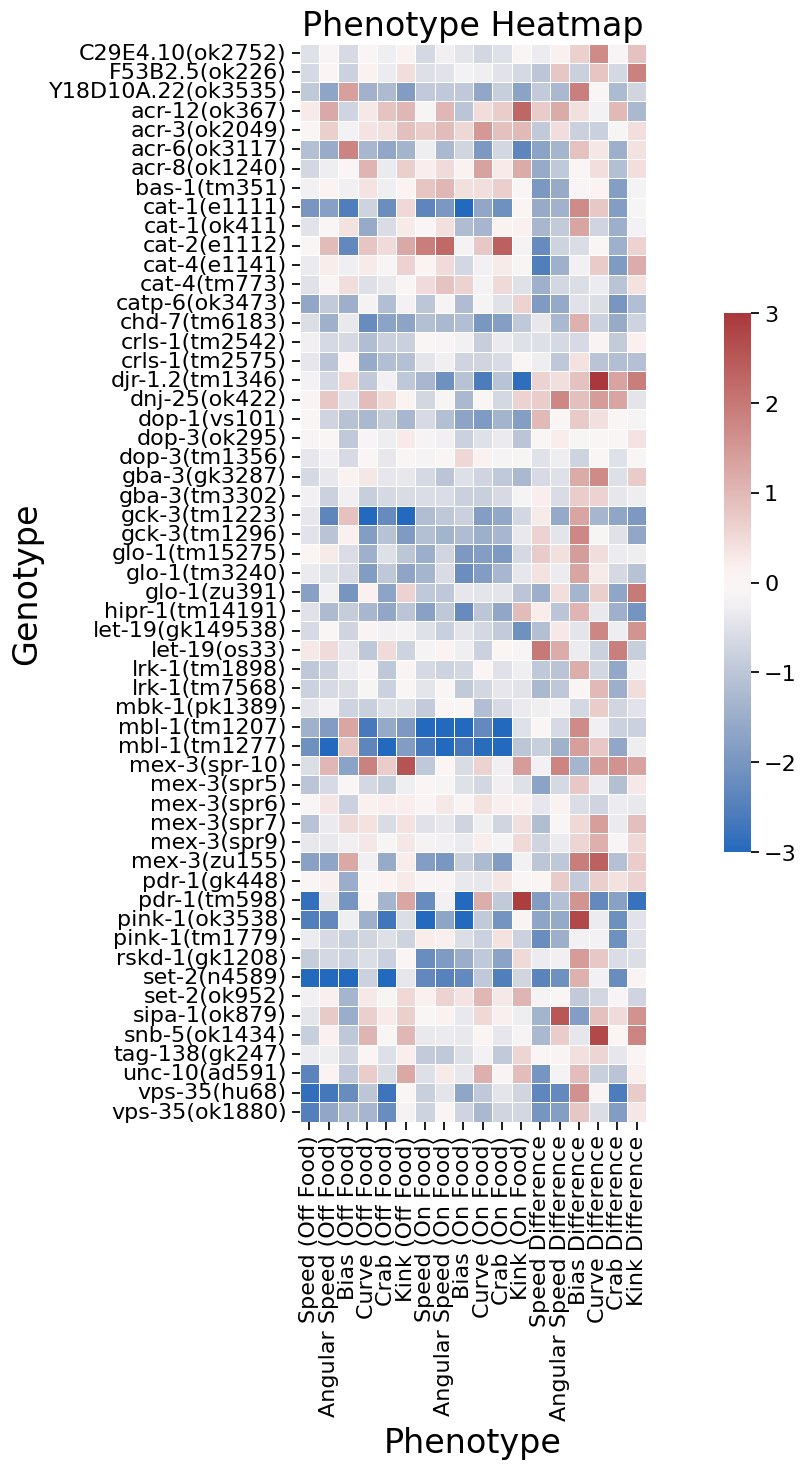

In [193]:
sns.set_context('notebook')
plt.figure(figsize = (20,14))
plt.rc('xtick', labelsize = 16)
plt.rc('ytick', labelsize = 16) 
ax = sns.heatmap(data = full_heatmap, 
                 annot = False, 
                 linewidth = 0.5, 
                 square = True, 
                 cmap = "vlag", 
                 center = 0, 
                 vmax = 3,
                 vmin = -3, 
                 # xticklabels = 1,
                 xticklabels = xlabels,
                 yticklabels = 1,
                 cbar_kws = {"shrink": .5,
                             # "label": "Normalized Behaviour Score"
                            })
ax.set_ylabel('Genotype', fontsize = 24)
ax.set_xlabel('Phenotype', fontsize = 24)
ax.set_title('Phenotype Heatmap', fontsize = 24)
# plt.savefig('BehaviourScore_GENE_normalized2_square.jpg', format='jpg', dpi=450, bbox_inches = "tight")
plt.savefig('Complete_Genotype_heatmap_normalized_square.jpg', format = 'jpg', dpi = 450, bbox_inches = "tight")
plt.show()

# Everything below not intended for large scale analysis of many strains, and include bugs that would need to be fixed (commented out so notebook can be run start to finish)

# By Gene

In [5]:
print(TotalConcatenated)
print(TotalConcatenated.Strain.unique())
TotalConcatenated_Gene = TotalConcatenated.groupby(["Strain", "worm"], as_index=False).mean()
TotalConcatenated_Gene[['Genotype', 'Treatment']] = TotalConcatenated_Gene['Strain'].str.split('_', expand = True)
TotalConcatenated_Gene = TotalConcatenated_Gene.dropna()
# TotalConcatenated_strains = TotalConcatenated_strains.Genotype.unique()
TotalConcatenated_Gene[['Gene','Allele']]=TotalConcatenated_Gene['Genotype'].str.split('(',expand=True)
TotalConcatenated_Gene['Allele']=TotalConcatenated_Gene['Allele'].str[:-1]
TotalConcatenated_Gene=TotalConcatenated_Gene.drop(columns=['Unnamed: 0'])
print(TotalConcatenated_Gene)


         Unnamed: 0  time_bin  worm        time     speed          x  \
0                 0       3.0     1    2.666125  0.352013  21.461862   
1                 1       3.0     8    2.546000  0.395982  27.712055   
2                 2       3.0    85    2.744000  0.324933  22.659617   
3                 3       3.0   165    2.776800  0.280820  19.180400   
4                 4       3.0   249    2.817250  0.216575  19.060475   
...             ...       ...   ...         ...       ...        ...   
4761605       34533     420.0   224  419.514417  0.144642  26.647400   
4761606       34534     420.0   226  419.514417  0.065600  16.178017   
4761607       34535     420.0   227  419.503545  0.131055  11.395073   
4761608       34536     420.0   231  419.514417  0.161325  17.991025   
4761609       34537     420.0   232  419.514417  0.123725  25.133917   

                 y  angularspeed  pathlength       kink      bias      curve  \
0        21.220437    134.875000    0.125875  82.212500

In [211]:
# TotalConcatenated_Gene=TotalConcatenated_Gene.drop(columns=["Allele", "x","y"])
print(TotalConcatenated_Gene)

                         Strain  worm  time_bin        time     speed  \
0      C29E4.10(ok2752)_OffFood     1     214.5  214.000409  0.151163   
1      C29E4.10(ok2752)_OffFood     2     179.5  178.999707  0.114384   
2      C29E4.10(ok2752)_OffFood     3      24.0   23.508306  0.146427   
3      C29E4.10(ok2752)_OffFood     4      38.0   37.500260  0.098544   
4      C29E4.10(ok2752)_OffFood     5      24.5   24.015099  0.126719   
...                         ...   ...       ...         ...       ...   
37308     vps-35(ok1880)_OnFood   229     249.0  248.502338  0.118773   
37309     vps-35(ok1880)_OnFood   230     293.0  292.495707  0.122036   
37310     vps-35(ok1880)_OnFood   231     348.0  347.502238  0.138274   
37311     vps-35(ok1880)_OnFood   232     348.0  347.502946  0.134496   
37312     vps-35(ok1880)_OnFood   233     326.5  325.999168  0.046806   

       angularspeed  pathlength       kink      bias      curve       dir  \
0         11.158125   27.058503  46.892847  0.

In [6]:


genes=TotalConcatenated_Gene.Gene.unique()
all_genes=pd.DataFrame(genes, columns = ['Gene'])
print(all_genes)

          Gene
0     C29E4.10
1      F53B2.5
2           N2
3   Y18D10A.22
4       acr-12
5        acr-3
6        acr-6
7        acr-8
8        bas-1
9        cat-1
10       cat-2
11       cat-4
12      catp-6
13       chd-7
14      crls-1
15     djr-1.2
16      dnj-25
17       dop-1
18       dop-3
19       gba-3
20       gck-3
21       glo-1
22      hipr-1
23      let-19
24       lrk-1
25       mbk-1
26       mbl-1
27       mex-3
28       pdr-1
29      pink-1
30      rskd-1
31       set-2
32      sipa-1
33       snb-5
34     tag-138
35      unc-10
36      vps-35


In [7]:
behavioural_phenotypes = ['speed', 'angularspeed', 'bias', 'curve', 'crab', 'kink']
# print(all_strains)

def gene_differences_of_differences(start, point, df):
    chunkeddata0 = df[df["time"] >= start]
    chunkeddata = chunkeddata0[chunkeddata0["time"] <= point]
#     chunkeddata_mean = chunkeddata.groupby(["Strain", "worm"], as_index=False).mean()
#     print(chunkeddata_mean)
#     chunkeddata_mean[['Gene', 'Treatment']] = chunkeddata_mean['Strain'].str.split('_', 1, expand=True)
    all_scores = all_genes
    for parameter in behavioural_phenotypes:
        worm_avg_parameter = chunkeddata[['Gene', 'Treatment', parameter]]
        avg_parameter = worm_avg_parameter.groupby(['Treatment', 'Gene'], as_index=False).mean()
#         print(avg_parameter)
        # avg_parameter.to_csv("avg_parameter.csv")
        parameter_diff = avg_parameter.drop(columns=["Treatment"])
#         print(parameter_diff)
        parameter_diff=parameter_diff.groupby(['Gene']).diff(periods=-1).dropna()
#         print(parameter_diff)
        parameter_diff.insert(loc=0, column='Gene', value = avg_parameter['Gene'].unique())
        parameter_diff.reset_index(drop=True)
#         print(parameter_diff)
        # print(parameter_diff.iloc[0,1])
        parameter_diff['Score'] = parameter_diff[parameter] - parameter_diff.iloc[2,1]
        print(parameter_diff)
        # parameter_diff = parameter_diff.sort_values(by = ["Score"])
        parameter_diff = parameter_diff.drop(columns = [parameter])
        parameter_diff = parameter_diff.rename(columns = {'Score':parameter})
        parameter_diff = parameter_diff.reset_index(drop = True)
        # print(parameter_diff)
        all_scores = all_scores.join(parameter_diff.iloc[:,1])
    all_scores = all_scores.set_index("Gene")
    return(all_scores)

gene_differences_of_differences(300, 400, TotalConcatenated_Gene)
Gene_Scores=gene_differences_of_differences(300, 400, TotalConcatenated_Gene)
print(Gene_Scores)

          Gene     speed     Score
0     C29E4.10  0.107229  0.006428
1      F53B2.5  0.065321 -0.035480
2           N2  0.100801  0.000000
3   Y18D10A.22  0.079438 -0.021363
4       acr-12  0.133423  0.032622
5        acr-3  0.074259 -0.026542
6        acr-6  0.065291 -0.035510
7        acr-8  0.060785 -0.040016
8        bas-1  0.042478 -0.058323
9        cat-1  0.053077 -0.047724
10       cat-2  0.009885 -0.090916
11       cat-4  0.030234 -0.070567
12      catp-6  0.000428 -0.100373
13       chd-7  0.109074  0.008273
14      crls-1  0.090043 -0.010758
15     djr-1.2  0.139226  0.038425
16      dnj-25  0.131147  0.030346
17       dop-1  0.137013  0.036212
18       dop-3  0.090310 -0.010491
19       gba-3  0.101818  0.001017
20       gck-3  0.125326  0.024525
21       glo-1  0.124538  0.023737
22      hipr-1  0.123596  0.022795
23      let-19  0.171096  0.070295
24       lrk-1  0.039850 -0.060951
25       mbk-1  0.095749 -0.005052
26       mbl-1  0.091764 -0.009037
27       mex-3  0.07

In [8]:
PD_gene_behavioural_scores_standardize = (Gene_Scores - Gene_Scores.mean())/Gene_Scores.std()
print(PD_gene_behavioural_scores_standardize)

PD_gene_behavioural_scores_normalize = PD_gene_behavioural_scores_standardize - PD_gene_behavioural_scores_standardize[PD_gene_behavioural_scores_standardize.index == 'N2'].squeeze()
print(PD_gene_behavioural_scores_normalize)
# PD_gene_behavioural_scores_normalize = PD_gene_behavioural_scores_normalize.drop(index = 'N2')
# print(PD_gene_behavioural_scores_normalize)


               speed  angularspeed      bias     curve      crab      kink
Gene                                                                      
C29E4.10    0.636546      0.765643  0.032474  1.545973  0.806160  0.664466
F53B2.5    -0.315722      0.952171  0.015969  1.062235 -0.178854  1.581792
N2          0.490489      0.211912 -0.574297 -0.356026  0.558058 -0.073074
Y18D10A.22  0.005059     -0.596928  1.134280  0.563526 -0.203554  0.040840
acr-12      1.231759      1.537655  0.259302 -0.243406  1.695853 -0.993290
acr-3      -0.112623      0.889424 -1.092200 -0.639855  0.777715  0.542539
acr-6      -0.316409     -0.597725  0.574798  0.257593 -0.313045  0.142931
acr-8      -0.418787     -0.586973 -0.279139 -0.080428 -0.425565 -0.281528
bas-1      -0.834797     -0.630686 -0.852366  0.422510 -0.695707  0.132581
cat-1      -0.593949     -0.683388  0.473918 -0.715392 -0.837871 -0.067232
cat-2      -1.575395     -0.468246 -1.258872 -0.068895 -0.988744  0.823999
cat-4      -1.113010     

In [11]:
print(PD_baseline_last100)
PD_baseline_last100_gene=PD_baseline_last100
PD_baseline_last100_gene[['Gene','Allele']]=PD_baseline_last100_gene['Genotype'].str.split('(',expand=True)
PD_baseline_last100_gene['Allele']=PD_baseline_last100_gene['Allele'].str[:-1]
PD_baseline_last100_gene=PD_baseline_last100_gene.drop(columns=['Allele'])
print(PD_baseline_last100_gene)

NameError: name 'PD_baseline_last100' is not defined

In [244]:
glist = PD_baseline_last100_gene["Gene"].unique()
print(glist)

['N2' 'C29E4.10' 'F53B2.5' 'Y18D10A.22' 'acr-12' 'acr-3' 'acr-6' 'acr-8'
 'bas-1' 'cat-1' 'cat-2' 'cat-4' 'catp-6' 'chd-7' 'crls-1' 'djr-1.2'
 'dnj-25' 'dop-1' 'dop-3' 'gba-3' 'gck-3' 'glo-1' 'hipr-1' 'let-19'
 'lrk-1' 'mbk-1' 'mbl-1' 'mex-3' 'pdr-1' 'pink-1' 'rskd-1' 'set-2'
 'sipa-1' 'snb-5' 'tag-138' 'unc-10' 'vps-35']


In [245]:
PD_baseline_last100_gene_OffFood = PD_baseline_last100_gene[PD_baseline_last100_gene["Treatment"] == "OffFood"].dropna().add_suffix('_OffFood')
PD_baseline_last100_gene_OffFood = PD_baseline_last100_gene_OffFood.rename(columns = {'Gene_OffFood': 'Gene'})
print(PD_baseline_last100_gene_OffFood)
PD_baseline_last100_gene_OnFood = PD_baseline_last100_gene[PD_baseline_last100_gene["Treatment"] == "OnFood"].dropna().add_suffix('_OnFood')
PD_baseline_last100_gene_OnFood = PD_baseline_last100_gene_OnFood.rename(columns = {'Gene_OnFood': 'Gene'})
print(PD_baseline_last100_gene_OnFood)

         time_bin_OffFood  worm_OffFood  time_OffFood  speed_OffFood  \
0                   301.0             3    300.494000       0.112342   
1                   301.0             5    300.526636       0.046927   
2                   301.0            13    300.494000       0.201983   
3                   301.0            14    300.494000       0.145258   
4                   301.0            15    300.494000       0.032808   
...                   ...           ...           ...            ...   
1065519             400.0           303    399.498667       0.042108   
1065520             400.0           304    399.570900       0.019800   
1065521             400.0           305    399.498667       0.079242   
1065522             400.0           307    399.498667       0.056133   
1065523             400.0           310    399.498667       0.017892   

         angularspeed_OffFood  pathlength_OffFood  kink_OffFood  bias_OffFood  \
0                   26.233333            0.979583    1

In [251]:
PD_gene_baseline_length_T = pd.DataFrame(columns = ["Genotype", "length"])
PD_gene_baseline_midline_T = pd.DataFrame(columns = ["Genotype", "midline"])
PD_gene_baseline_width_T = pd.DataFrame(columns = ["Genotype", "width"])
PD_gene_baseline_morphwidth_T = pd.DataFrame(columns = ["Genotype", "morphwidth"])
PD_gene_baseline_area_T = pd.DataFrame(columns = ["Genotype", "area"])

PD_gene_baseline_speed_T_OffFood = pd.DataFrame(columns = ["Gene", "speed_OffFood"])
PD_gene_baseline_angularspeed_T_OffFood = pd.DataFrame(columns = ["Gene", "angularspeed_OffFood"])
PD_gene_baseline_bias_T_OffFood = pd.DataFrame(columns = ["Gene", "bias_OffFood"])
PD_gene_baseline_curve_T_OffFood = pd.DataFrame(columns = ["Gene", "curve_OffFood"])
PD_gene_baseline_crab_T_OffFood = pd.DataFrame(columns = ["Gene", "crab_OffFood"])
PD_gene_baseline_kink_T_OffFood = pd.DataFrame(columns = ["Gene", "kink_OffFood"])

PD_gene_baseline_speed_T_OnFood = pd.DataFrame(columns = ["Gene", "speed_OnFood"])
PD_gene_baseline_angularspeed_T_OnFood = pd.DataFrame(columns = ["Gene", "angularspeed_OnFood"])
PD_gene_baseline_bias_T_OnFood = pd.DataFrame(columns = ["Gene", "bias_OnFood"])
PD_gene_baseline_curve_T_OnFood = pd.DataFrame(columns = ["Gene", "curve_OnFood"])
PD_gene_baseline_crab_T_OnFood = pd.DataFrame(columns = ["Gene", "crab_OnFood"])
PD_gene_baseline_kink_T_OnFood = pd.DataFrame(columns = ["Gene", "kink_OnFood"])

In [248]:
def TTest_Gene(DatasetList, Type, DF_ref, output):
    for a in DatasetList:
        Tstat = ttest_ind(DF_ref[DF_ref.Gene == a][Type], DF_ref[DF_ref.Gene == "N2"][Type], equal_var = False)[0]
        row = [a, Tstat]
        output.loc[len(output)] = row
    print(output)

In [252]:
TTest_Gene(PD_baseline_last100_gene["Gene"].unique(), "speed_OffFood",
           PD_baseline_last100_gene_OffFood, PD_gene_baseline_speed_T_OffFood)
TTest_Gene(PD_baseline_last100_gene["Gene"].unique(), "angularspeed_OffFood",
           PD_baseline_last100_gene_OffFood, PD_gene_baseline_angularspeed_T_OffFood)
TTest_Gene(PD_baseline_last100_gene["Gene"].unique(), "bias_OffFood",
           PD_baseline_last100_gene_OffFood, PD_gene_baseline_bias_T_OffFood)
TTest_Gene(PD_baseline_last100_gene["Gene"].unique(), "curve_OffFood",
           PD_baseline_last100_gene_OffFood, PD_gene_baseline_curve_T_OffFood)
TTest_Gene(PD_baseline_last100_gene["Gene"].unique(), "crab_OffFood",
           PD_baseline_last100_gene_OffFood, PD_gene_baseline_crab_T_OffFood)
TTest_Gene(PD_baseline_last100_gene["Gene"].unique(), "kink_OffFood",
           PD_baseline_last100_gene_OffFood, PD_gene_baseline_kink_T_OffFood)

TTest_Gene(PD_baseline_last100_gene["Gene"].unique(), "speed_OnFood",
           PD_baseline_last100_gene_OnFood, PD_gene_baseline_speed_T_OnFood)
TTest_Gene(PD_baseline_last100_gene["Gene"].unique(), "angularspeed_OnFood",
           PD_baseline_last100_gene_OnFood, PD_gene_baseline_angularspeed_T_OnFood)
TTest_Gene(PD_baseline_last100_gene["Gene"].unique(), "bias_OnFood",
           PD_baseline_last100_gene_OnFood, PD_gene_baseline_bias_T_OnFood)
TTest_Gene(PD_baseline_last100_gene["Gene"].unique(), "curve_OnFood",
           PD_baseline_last100_gene_OnFood, PD_gene_baseline_curve_T_OnFood)
TTest_Gene(PD_baseline_last100_gene["Gene"].unique(), "crab_OnFood",
           PD_baseline_last100_gene_OnFood, PD_gene_baseline_crab_T_OnFood)
TTest_Gene(PD_baseline_last100_gene["Gene"].unique(), "kink_OnFood",
           PD_baseline_last100_gene_OnFood, PD_gene_baseline_kink_T_OnFood)

          Gene  speed_OffFood
0           N2       0.000000
1     C29E4.10     -39.596125
2      F53B2.5     -50.897369
3   Y18D10A.22     -73.593994
4       acr-12      20.350617
5        acr-3      -7.246292
6        acr-6     -89.438005
7        acr-8     -54.375145
8        bas-1     -17.844158
9        cat-1     -85.568627
10       cat-2      -0.083642
11       cat-4     -44.140929
12      catp-6    -127.391213
13       chd-7     -43.609987
14      crls-1     -35.221674
15     djr-1.2     -16.314944
16      dnj-25       6.099015
17       dop-1      -5.214501
18       dop-3     -19.753177
19       gba-3     -36.601055
20       gck-3     -46.215897
21       glo-1     -53.506116
22      hipr-1     -37.925383
23      let-19      10.730583
24       lrk-1     -96.464744
25       mbk-1     -33.670362
26       mbl-1    -175.372947
27       mex-3    -116.167448
28       pdr-1     -96.230942
29      pink-1     -90.975279
30      rskd-1     -69.273414
31       set-2     -85.911407
32      si

          Gene  bias_OnFood
0           N2     0.000000
1     C29E4.10   -17.310061
2      F53B2.5    -8.120512
3   Y18D10A.22   -37.803306
4       acr-12   -39.778493
5        acr-3    21.416052
6        acr-6   -28.191194
7        acr-8     5.502644
8        bas-1    16.369983
9        cat-1   -93.716043
10       cat-2    -6.629063
11       cat-4    -7.096575
12      catp-6   -47.888449
13       chd-7   -46.068766
14      crls-1   -26.362032
15     djr-1.2   -43.179688
16      dnj-25   -50.261048
17       dop-1   -66.765539
18       dop-3   -19.265366
19       gba-3   -37.180138
20       gck-3   -50.062327
21       glo-1   -96.587251
22      hipr-1   -88.125489
23      let-19   -18.739395
24       lrk-1   -45.160324
25       mbk-1    -0.166147
26       mbl-1  -156.361972
27       mex-3   -43.196911
28       pdr-1   -68.209732
29      pink-1   -51.132931
30      rskd-1   -59.176784
31       set-2    -7.625500
32      sipa-1   -14.433168
33       snb-5   -14.718663
34     tag-138   -21

In [255]:
PD_gene_baseline_Tstats = PD_gene_baseline_speed_T_OffFood
PD_gene_baseline_Tstats = PD_gene_baseline_Tstats.join(PD_gene_baseline_angularspeed_T_OffFood.iloc[:,1])
PD_gene_baseline_Tstats = PD_gene_baseline_Tstats.join(PD_gene_baseline_bias_T_OffFood.iloc[:,1])
PD_gene_baseline_Tstats = PD_gene_baseline_Tstats.join(PD_gene_baseline_curve_T_OffFood.iloc[:,1])
PD_gene_baseline_Tstats = PD_gene_baseline_Tstats.join(PD_gene_baseline_crab_T_OffFood.iloc[:,1])
PD_gene_baseline_Tstats = PD_gene_baseline_Tstats.join(PD_gene_baseline_kink_T_OffFood.iloc[:,1])

PD_gene_baseline_Tstats = PD_gene_baseline_Tstats.join(PD_gene_baseline_speed_T_OnFood.iloc[:,1])
PD_gene_baseline_Tstats = PD_gene_baseline_Tstats.join(PD_gene_baseline_angularspeed_T_OnFood.iloc[:,1])
PD_gene_baseline_Tstats = PD_gene_baseline_Tstats.join(PD_gene_baseline_bias_T_OnFood.iloc[:,1])
PD_gene_baseline_Tstats = PD_gene_baseline_Tstats.join(PD_gene_baseline_curve_T_OnFood.iloc[:,1])
PD_gene_baseline_Tstats = PD_gene_baseline_Tstats.join(PD_gene_baseline_crab_T_OnFood.iloc[:,1])
PD_gene_baseline_Tstats = PD_gene_baseline_Tstats.join(PD_gene_baseline_kink_T_OnFood.iloc[:,1])

PD_gene_baseline_Tstats = PD_gene_baseline_Tstats.set_index("Gene")
print(PD_gene_baseline_Tstats)

            speed_OffFood  angularspeed_OffFood  bias_OffFood  curve_OffFood  \
Gene                                                                           
N2               0.000000              0.000000      0.000000       0.000000   
C29E4.10       -39.596125             -3.556830    -10.050036       0.281699   
F53B2.5        -50.897369              0.993466    -13.002905       5.834548   
Y18D10A.22     -73.593994            -58.908084     22.271502     -59.973634   
acr-12          20.350617             43.435596    -11.964313      12.263381   
acr-3           -7.246292             23.138608     -3.400442      15.447829   
acr-6          -89.438005            -53.517291     29.577208     -55.539005   
acr-8          -54.375145            -10.304750      0.086315      45.805464   
bas-1          -17.844158              4.025946     -4.137099      16.071554   
cat-1          -85.568627            -29.197011    -17.603006     -69.478851   
cat-2           -0.083642             33

In [256]:
PD_gene_baseline_Tstats = PD_gene_baseline_Tstats.dropna().sort_index()

PD_gene_baseline_Tstats_standardize = (PD_gene_baseline_Tstats - PD_gene_baseline_Tstats.mean())/PD_gene_baseline_Tstats.std()
print(PD_gene_baseline_Tstats_standardize)

PD_gene_baseline_Tstats_normalize = PD_gene_baseline_Tstats_standardize - PD_gene_baseline_Tstats_standardize[PD_gene_baseline_Tstats_standardize.index == 'N2'].squeeze()
print(PD_gene_baseline_Tstats_normalize)
PD_gene_baseline_Tstats_normalize = PD_gene_baseline_Tstats_normalize.drop(index = 'N2')
print(PD_gene_baseline_Tstats_normalize)

            speed_OffFood  angularspeed_OffFood  bias_OffFood  curve_OffFood  \
Gene                                                                           
C29E4.10         0.332096              0.425106      0.017250       0.470076   
F53B2.5          0.141296              0.557390     -0.164418       0.583072   
N2               1.000602              0.528508      0.635557       0.464344   
Y18D10A.22      -0.241893             -1.184031      2.005762      -0.756066   
acr-12           1.344184              1.791241     -0.100521       0.713893   
acr-3            0.878262              1.201180      0.426352       0.778694   
acr-6           -0.509390             -1.027314      2.455229      -0.665825   
acr-8            0.082581              0.228935      0.640867       1.396444   
bas-1            0.699337              0.645548      0.381031       0.791386   
cat-1           -0.444062             -0.320289     -0.447430      -0.949488   
cat-2            0.999190              1

In [262]:
full_heatmap = PD_gene_baseline_Tstats_normalize.join(PD_gene_behavioural_scores_normalize)
full_heatmap=full_heatmap.reset_index().rename(columns={"Gene":"dataset"})
print(full_heatmap)

       dataset  speed_OffFood  angularspeed_OffFood  bias_OffFood  \
0     C29E4.10      -0.668506             -0.103402     -0.618306   
1      F53B2.5      -0.859306              0.028881     -0.799975   
2   Y18D10A.22      -1.242495             -1.712540      1.370205   
3       acr-12       0.343582              1.262733     -0.736078   
4        acr-3      -0.122340              0.672671     -0.209205   
5        acr-6      -1.509992             -1.555822      1.819673   
6        acr-8      -0.918022             -0.299573      0.005310   
7        bas-1      -0.301265              0.117040     -0.254526   
8        cat-1      -1.444664             -0.848798     -1.082986   
9        cat-2      -0.001412              0.973285     -2.316053   
10       cat-4      -0.745236              0.222364      0.147647   
11      catp-6      -2.150760             -0.909038     -1.481246   
12       chd-7      -0.736272             -1.471191     -0.356257   
13      crls-1      -0.594651     

In [18]:
Gene_Orthology=pd.read_csv('/Users/Joseph/Desktop/GRC_Data/Gene_Orthology.csv')
Gene_Orthology=Gene_Orthology.rename(columns={"Gene":"Orthology", "Worm Gene":"dataset"})
Gene_Orthology=Gene_Orthology.drop(columns=['Unnamed: 0'])
print(Gene_Orthology)

               Orthology   dataset    Human Gene
0            KCNS3•kvs-5     kvs-5         KCNS3
1            LAMB2•lam-1     lam-1         LAMB2
2              GBA•gba-4     gba-4           GBA
3         ATP13A3•catp-6    catp-6       ATP13A3
4           MCCC1•mccc-1    mccc-1         MCCC1
..                   ...       ...           ...
88  FAM49B\CYRIB•R07G3.8   R07G3.8  FAM49B\CYRIB
89          MED13•let-19    let-19         MED13
90           CLCN3•clh-5     clh-5         CLCN3
91       CAB39L•mop-25.2  mop-25.2        CAB39L
92                 WT•N2        N2            WT

[93 rows x 3 columns]


In [16]:
# PD_gene_behavioural_scores_normalize=PD_gene_behavioural_scores_normalize.reset_index()
PD_gene_behavioural_scores_normalize=PD_gene_behavioural_scores_normalize.rename(columns={"Gene":"dataset"}).drop(columns=['index'])
print(PD_gene_behavioural_scores_normalize)

       dataset     speed  angularspeed      bias     curve      crab      kink
0     C29E4.10  0.146056      0.553731  0.606771  1.901999  0.248102  0.737541
1      F53B2.5 -0.806212      0.740259  0.590266  1.418261 -0.736912  1.654866
2           N2  0.000000      0.000000  0.000000  0.000000  0.000000  0.000000
3   Y18D10A.22 -0.485431     -0.808840  1.708577  0.919552 -0.761612  0.113914
4       acr-12  0.741270      1.325743  0.833599  0.112621  1.137795 -0.920216
5        acr-3 -0.603113      0.677512 -0.517903 -0.283829  0.219656  0.615613
6        acr-6 -0.806898     -0.809636  1.149094  0.613619 -0.871103  0.216005
7        acr-8 -0.909277     -0.798884  0.295157  0.275598 -0.983623 -0.208453
8        bas-1 -1.325286     -0.842598 -0.278069  0.778536 -1.253766  0.205656
9        cat-1 -1.084439     -0.895300  1.048215 -0.359366 -1.395929  0.005842
10       cat-2 -2.065884     -0.680157 -0.684575  0.287131 -1.546802  0.897074
11       cat-4 -1.603499     -1.176340  0.043084  0.

In [19]:
Orthology_full_heatmap=pd.merge(PD_gene_behavioural_scores_normalize,
                                 Gene_Orthology,
                                 on='dataset',
                                 how='inner')

print(Orthology_full_heatmap)

       dataset     speed  angularspeed      bias     curve      crab  \
0     C29E4.10  0.146056      0.553731  0.606771  1.901999  0.248102   
1      F53B2.5 -0.806212      0.740259  0.590266  1.418261 -0.736912   
2           N2  0.000000      0.000000  0.000000  0.000000  0.000000   
3   Y18D10A.22 -0.485431     -0.808840  1.708577  0.919552 -0.761612   
4       acr-12  0.741270      1.325743  0.833599  0.112621  1.137795   
5        acr-3 -0.603113      0.677512 -0.517903 -0.283829  0.219656   
6        acr-6 -0.806898     -0.809636  1.149094  0.613619 -0.871103   
7        acr-8 -0.909277     -0.798884  0.295157  0.275598 -0.983623   
8        bas-1 -1.325286     -0.842598 -0.278069  0.778536 -1.253766   
9        cat-1 -1.084439     -0.895300  1.048215 -0.359366 -1.395929   
10       cat-2 -2.065884     -0.680157 -0.684575  0.287131 -1.546802   
11       cat-4 -1.603499     -1.176340  0.043084  0.003576 -1.300926   
12      catp-6 -2.280775     -2.103777  0.732917 -0.694272 -2.56

<Figure size 640x480 with 0 Axes>

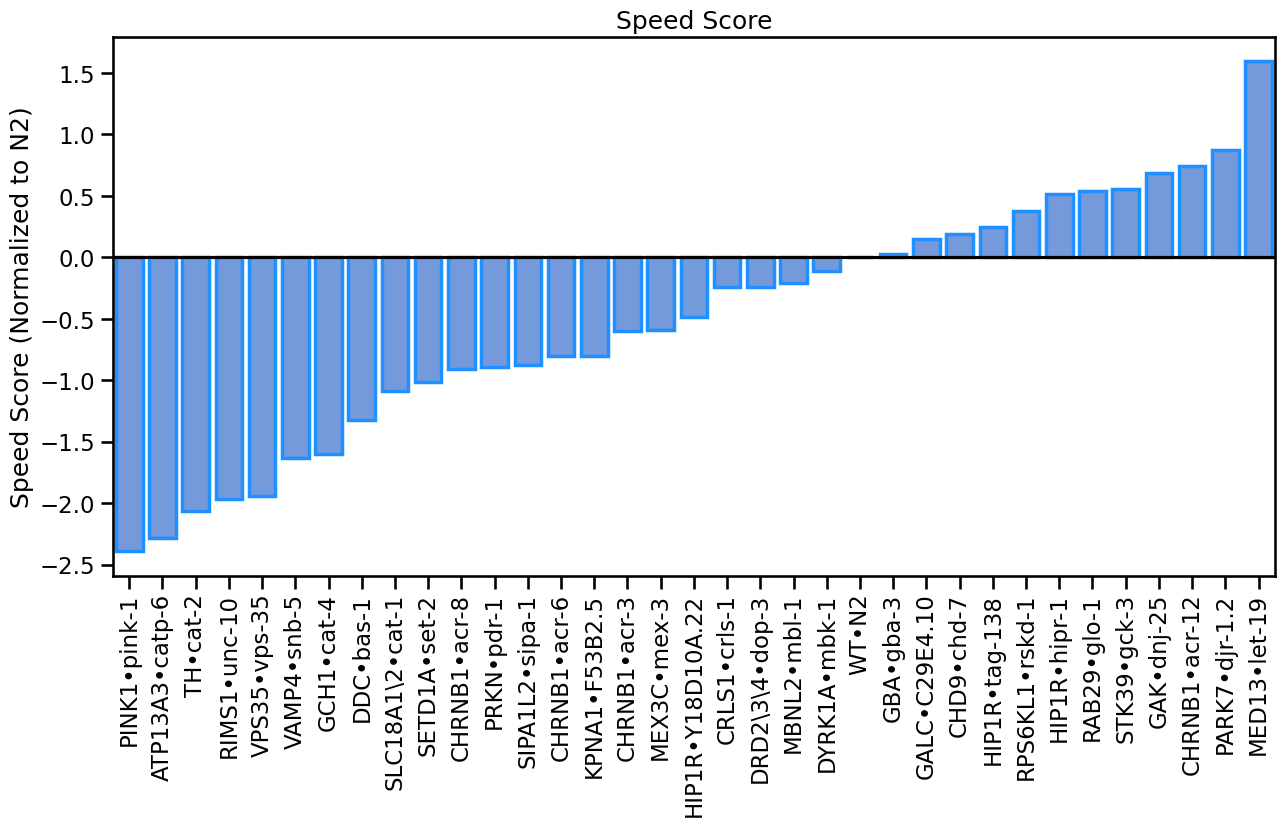

In [24]:
# behavioural_phenotypes = ['speed', 'angularspeed', 'bias', 'curve', 'crab', 'kink']
parameter='speed'

Title = f"{parameter.capitalize()} Score"  # <---------------- Input Here -----------------
sns.set_context("talk")
plt.figure(linewidth = 1)
plt.figure(figsize = (15, 7))
plt.gca().xaxis.grid(False)
ax = sns.barplot(x = "Orthology",
                 y = f'{parameter}',
                 data = Orthology_full_heatmap.sort_values(by=[f'{parameter}']),  # <--------------- Input Here -------------
                 color = 'CornflowerBlue',
                 edgecolor = "DodgerBlue",
                 linewidth = 2.5,
                )

plt.xlabel("")
plt.xticks(rotation = 90)
plt.ylabel(f"{parameter.capitalize()} Score (Normalized to N2)")
plt.axhline(0, color='black')
# plt.ylim(top = 0.1)
# plt.ylim(bottom = -0.1)
plt.title(Title)
# plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)

plt.savefig(f'Gene {Title}.jpg', format = 'jpg', dpi = 450, bbox_inches = 'tight')

plt.show()

In [275]:
Orthology_full_heatmap_final=Orthology_full_heatmap.set_index("Orthology").drop(columns=['dataset','Human Gene'])
print(Orthology_full_heatmap_final)

                  speed_OffFood  angularspeed_OffFood  bias_OffFood  \
Orthology                                                             
GALC•C29E4.10         -0.668506             -0.103402     -0.618306   
KPNA1•F53B2.5         -0.859306              0.028881     -0.799975   
HIP1R•Y18D10A.22      -1.242495             -1.712540      1.370205   
CHRNB1•acr-12          0.343582              1.262733     -0.736078   
CHRNB1•acr-3          -0.122340              0.672671     -0.209205   
CHRNB1•acr-6          -1.509992             -1.555822      1.819673   
CHRNB1•acr-8          -0.918022             -0.299573      0.005310   
DDC•bas-1             -0.301265              0.117040     -0.254526   
SLC18A1\2•cat-1       -1.444664             -0.848798     -1.082986   
TH•cat-2              -0.001412              0.973285     -2.316053   
GCH1•cat-4            -0.745236              0.222364      0.147647   
ATP13A3•catp-6        -2.150760             -0.909038     -1.481246   
CHD9•c

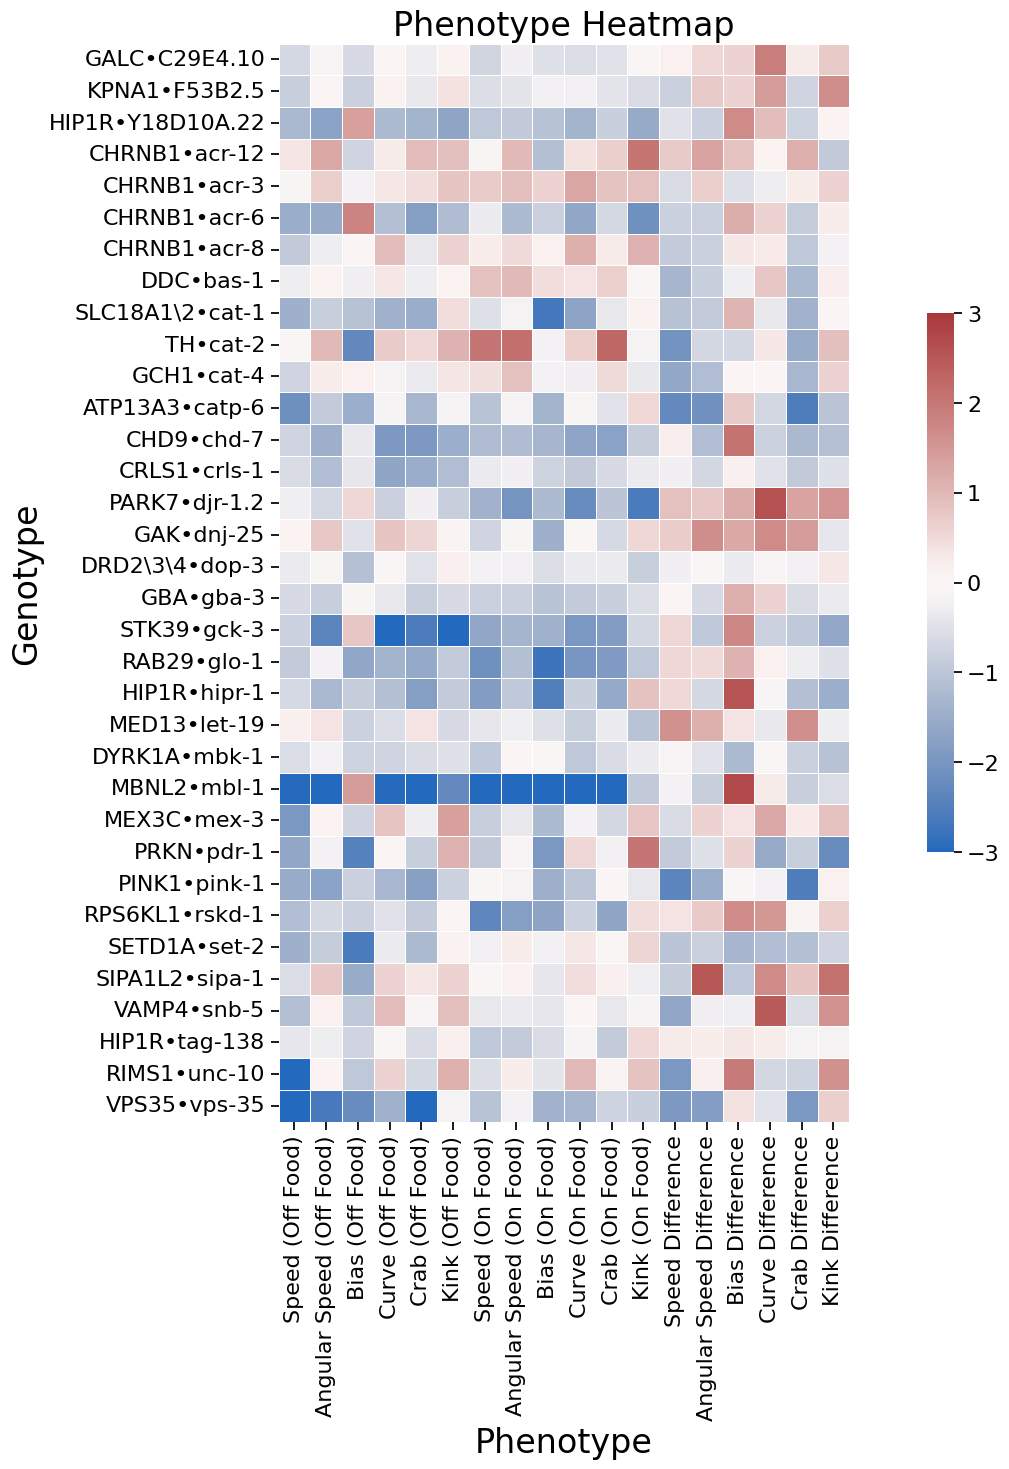

In [276]:
sns.set_context('notebook')
plt.figure(figsize = (20,14))
plt.rc('xtick', labelsize = 16)
plt.rc('ytick', labelsize = 16) 
ax = sns.heatmap(data = Orthology_full_heatmap_final, 
                 annot = False, 
                 linewidth = 0.5, 
                 square = True, 
                 cmap = "vlag", 
                 center = 0, 
                 vmax = 3,
                 vmin = -3, 
                 # xticklabels = 1,
                 xticklabels = xlabels,
                 yticklabels = 1,
                 cbar_kws = {"shrink": .5,
                             # "label": "Normalized Behaviour Score"
                            })
ax.set_ylabel('Genotype', fontsize = 24)
ax.set_xlabel('Phenotype', fontsize = 24)
ax.set_title('Phenotype Heatmap', fontsize = 24)
# plt.savefig('BehaviourScore_GENE_normalized2_square.jpg', format='jpg', dpi=450, bbox_inches = "tight")
plt.savefig('Complete_Gene_heatmap_normalized_square.jpg', format = 'jpg', dpi = 450, bbox_inches = "tight")
plt.show()

# Graphing Bar Graphs

## Speed Barplots Comparison

In [33]:
# # Valid Measurement inputs(change var)
# # 1:'speed', <---
# # 2: "x",
# # 3: "y",
# # 4: "angularspeed", <-----
# # 5: "pathlength",
# # 6: "kink",  <---
# # 7: "bias", <----
# # 8: "curve", <---
# # 9: "dir",<----
# # 10: "crab",<----
# # 11: "length",<---
# # 12: "midline",<----
# # 13: "width",<----
# # 14: "morphwidth",<----
# # 15: "area"<----

# start = 200
# point = 400
# var = "area"
# chunkeddata0 = TotalConcatenated[TotalConcatenated["time"] >= start]
# chunkeddata = chunkeddata0[chunkeddata0["time"] <= point]
# chunkeddata_mean = chunkeddata.groupby(["Strain","worm"], as_index=False).mean()
# chunkeddata_mean[['Genotype', 'Treatment']] = chunkeddata_mean['Strain'].str.split(' - ', 1, expand=True)

# Title = f"{var} - {start}-{point} seconds" #<---------------- Input Here -----------------
# sns.set_context("talk")
# plt.figure(linewidth = 2.5)
# plt.figure(figsize=(15, 3))
# plt.gca().xaxis.grid(False)
# ax = sns.barplot(x="Genotype", 
#              y = var, 
#              data = chunkeddata_mean, #<--------------- Input Here -------------
#              hue = 'Treatment',
#              edgecolor="black",
#              linewidth = 2.5,
# #              seed=5,
#              ci = 95, # 'sd' for SD, '68' for SEM
#              palette = ['grey',
#                         'black'
#                        ]
#                 )
# plt.xlabel("Strain and Condition")
# # plt.ylabel("Average Speed (mm/s)")
# plt.title(Title)
# plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
# plt.savefig(f'{Title}.png', format='png', dpi=450, bbox_inches = 'tight')
# plt.show()

In [34]:
# Test Cell
# chunkeddata_mean

In [35]:
# Test Cell
# TotalConcatenated.describe()
# chunkeddata0
# chunkeddata

## Bias Barplots Comparison

In [36]:
# point = 420
# var = "bias"
# chunkeddata0 = TotalConcatenated[TotalConcatenated["time"] >= 0]
# chunkeddata = chunkeddata0[chunkeddata0["time"] <= point]

# Title = f"{var} - First {point} seconds" #<---------------- Input Here -----------------
# sns.set_context("talk")
# plt.figure(linewidth = 2.5)
# plt.figure(figsize=(15, 5))
# plt.gca().xaxis.grid(False)
# ax = sns.barplot(x="Genotype", 
#              y = var, 
#              data = chunkeddata, #<--------------- Input Here -------------
#              hue = 'Treatment',
#              edgecolor="black",
#              linewidth = 2.5,
#              ci = None,
#              palette = ['black',
#                         'grey'
#                        ]
#                 )
# plt.xlabel("Strain and Condition")
# # plt.ylabel("Average Speed (mm/s)")
# plt.title(Title)
# plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
# # plt.savefig(f'{Title}.png', format='png', dpi=450, bbox_inches = 'tight')
# plt.show()